## Data Cleaning and EDA

### Two datasets provided
The data sets contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.

- Training set: the dataset we will be using to develop, train and test our model.

- Holdout set: a dataset of predictors without sale price. Using our model, we will come out with sale price prediction. Kaggle, who knows the answers to the sale prices corresponding to this data set will then give a score based on how well our the predicts sale price.
    
The datasets were concatenated so that handling of missing data and coding of variables will be the same between the 2 sets. A column is create to identify the origin of the observations. The datasets have a total of 81 columns. The train.csv has 2051 rows and the test.csv has 879 rows of data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score

#plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
test.Id.sort_values(ascending=True)

704       2
706       4
120       6
312       7
401      17
       ... 
537    2919
179    2921
829    2922
669    2925
675    2928
Name: Id, Length: 879, dtype: int64

In [4]:
train.Id.sort_values(ascending=True)

1080       1
304        3
574        5
1673       8
458        9
        ... 
1013    2924
1478    2926
416     2927
651     2929
522     2930
Name: Id, Length: 2051, dtype: int64

In [5]:
print(train.shape, test.shape)

(2051, 81) (879, 80)


In [6]:
#Adding a column to id that it is from train or test set
train['data_from'] = 'train'
test['data_from'] = 'test'


In [7]:
ames = pd.concat([train, test])
ames.shape

(2930, 82)

In [8]:
missing_count = ames.isnull().sum().sort_values(ascending=False)[ames.isnull().sum().sort_values(ascending=False)>0]
missing_count

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
SalePrice          879
Lot Frontage       490
Garage Yr Blt      159
Garage Qual        159
Garage Finish      159
Garage Cond        159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
BsmtFin Type 1      80
Bsmt Cond           80
Bsmt Qual           80
Mas Vnr Area        23
Mas Vnr Type        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Total Bsmt SF        1
Electrical           1
dtype: int64

In [9]:
#% of missing value
missing_percent=round(missing_count/2930, 2)
missing_percent

Pool QC           1.00
Misc Feature      0.96
Alley             0.93
Fence             0.80
Fireplace Qu      0.49
SalePrice         0.30
Lot Frontage      0.17
Garage Yr Blt     0.05
Garage Qual       0.05
Garage Finish     0.05
Garage Cond       0.05
Garage Type       0.05
Bsmt Exposure     0.03
BsmtFin Type 2    0.03
BsmtFin Type 1    0.03
Bsmt Cond         0.03
Bsmt Qual         0.03
Mas Vnr Area      0.01
Mas Vnr Type      0.01
Bsmt Half Bath    0.00
Bsmt Full Bath    0.00
Garage Area       0.00
Garage Cars       0.00
Bsmt Unf SF       0.00
BsmtFin SF 2      0.00
BsmtFin SF 1      0.00
Total Bsmt SF     0.00
Electrical        0.00
dtype: float64

In [10]:
#drop those that have 80% or more missing 

ames.drop(["Misc Feature", "Alley", "Fence", 'Pool QC' ], axis=1, inplace=True)
ames.shape

(2930, 78)

In [11]:
#filter and print out only those with more than 0 isnull and sort them in decreasing order

ames.isnull().sum().sort_values(ascending=False)[ames.isnull().sum().sort_values(ascending=False)>0]

Fireplace Qu      1422
SalePrice          879
Lot Frontage       490
Garage Qual        159
Garage Finish      159
Garage Cond        159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Electrical           1
Total Bsmt SF        1
dtype: int64

In [12]:
ames.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  109  533352170           60        RL           NaN     13517   Pave   
1  544  531379050           60        RL          43.0     11492   Pave   
2  153  535304180           20        RL          68.0      7922   Pave   
3  318  916386060           60        RL          73.0      9802   Pave   
4  255  906425045           50        RL          82.0     14235   Pave   

  Lot Shape Land Contour Utilities  ... Enclosed Porch 3Ssn Porch  \
0       IR1          Lvl    AllPub  ...              0          0   
1       IR1          Lvl    AllPub  ...              0          0   
2       Reg          Lvl    AllPub  ...              0          0   
3       Reg          Lvl    AllPub  ...              0          0   
4       IR1          Lvl    AllPub  ...              0          0   

  Screen Porch Pool Area Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  \
0            0         0        0       3    2010        WD    130500.0   
1            0         0        0       4    2009        WD    220000.0   
2            0         0        0       1    2010        WD    109000.0   
3            0         0        0       4    2010        WD    174000.0   
4            0         0        0       3    2010        WD    138500.0   

   data_from  
0      train  
1      train  
2      train  
3      train  
4      train  

[5 rows x 78 columns]

In [13]:
ames.tail()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
874  1662  527377110           60        RL          80.0      8000   Pave   
875  1234  535126140           60        RL          90.0     14670   Pave   
876  1373  904100040           20        RL          55.0      8250   Pave   
877  1672  527425140           20        RL          60.0      9000   Pave   
878  1939  535327160           20        RL          70.0      8400   Pave   

    Lot Shape Land Contour Utilities  ... Enclosed Porch 3Ssn Porch  \
874       Reg          Lvl    AllPub  ...              0          0   
875       Reg          Lvl    AllPub  ...              0          0   
876       Reg          Lvl    AllPub  ...              0          0   
877       Reg          Lvl    AllPub  ...              0          0   
878       Reg          Lvl    AllPub  ...              0          0   

    Screen Porch Pool Area Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  \
874            0         0        0      11    2007        WD         NaN   
875            0         0        0       8    2008        WD         NaN   
876            0         0        0       8    2008        WD         NaN   
877            0         0        0       5    2007        WD         NaN   
878            0         0        0       3    2007        WD         NaN   

     data_from  
874       test  
875       test  
876       test  
877       test  
878       test  

[5 rows x 78 columns]

In [14]:
#can see total entries, total columns (ie. tell you the shape as well), number of entries per col and data types
#thus we dont need .dtypes and .shape

ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 878
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual   

In [15]:
#lets check if those values really correspond
#if they ask about garage area and they dont have a garage, the garage finish should also be NaN

print(ames.loc[ames["Mas Vnr Area"].isnull(), ["Mas Vnr Type", "Mas Vnr Area"]])
print("---------------------------------")
print(ames.loc[ames["Bsmt Full Bath"].isnull(), ["BsmtFin Type 1", "Bsmt Full Bath"]])
print("---------------------------------")
print(ames.loc[ames["Bsmt Half Bath"].isnull(), ["BsmtFin Type 1", "Bsmt Half Bath"]])
print("---------------------------------")
print(ames.loc[ames["BsmtFin SF 1"].isnull(), ["BsmtFin Type 1", "BsmtFin SF 1"]])
print("---------------------------------")
print(ames.loc[ames["Garage Cars"].isnull(), ["Garage Finish", "Garage Cars"]])
print("---------------------------------")
print(ames.loc[ames["Garage Area"].isnull(), ["Garage Finish", "Garage Area"]])
print("---------------------------------")
print(ames.loc[ames["BsmtFin SF 2"].isnull(), ["BsmtFin Type 1", "BsmtFin SF 2"]])
print("---------------------------------")
print(ames.loc[ames["Total Bsmt SF"].isnull(), ["BsmtFin Type 1", "Total Bsmt SF"]])
print("---------------------------------")
print(ames.loc[ames["Bsmt Unf SF"].isnull(), ["BsmtFin Type 1", "Bsmt Unf SF"]])
print("---------------------------------")
print(ames.loc[ames["Fireplace Qu"].isnull(), ["Fireplace Qu", "Fireplaces"]])


     Mas Vnr Type  Mas Vnr Area
22            NaN           NaN
41            NaN           NaN
86            NaN           NaN
212           NaN           NaN
276           NaN           NaN
338           NaN           NaN
431           NaN           NaN
451           NaN           NaN
591           NaN           NaN
844           NaN           NaN
913           NaN           NaN
939           NaN           NaN
1025          NaN           NaN
1244          NaN           NaN
1306          NaN           NaN
1430          NaN           NaN
1434          NaN           NaN
1606          NaN           NaN
1699          NaN           NaN
1815          NaN           NaN
1820          NaN           NaN
1941          NaN           NaN
866           NaN           NaN
---------------------------------
     BsmtFin Type 1  Bsmt Full Bath
616             NaN             NaN
1327            NaN             NaN
---------------------------------
     BsmtFin Type 1  Bsmt Half Bath
616             NaN 

In [16]:
#Check they are gone
ames.columns


Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', '

In [17]:
#now that we know it is highly likely those missing are because they dont have this feature in their house
#for those that are dtype objects, lets fill with donthave so it will be a dummy column later
#but since we going to one-hot encode the dummy var, it will be dropped later anyway~

for col in ames:
    if ames[col].dtype == "O":
        ames[col].fillna("donthave", inplace=True)
    else:
        pass
    

In [18]:
#loop all column to impute NaN to 0 if they are int and float types

for col in ames:
    if ames[col].dtype == "int64" or "float64":
        ames[col].fillna(value=0, inplace=True)
    else:
        pass

In [19]:
#WOW!!! like no missing like that!! lol ><

ames.isnull().sum().sort_values(ascending=False)[ames.isnull().sum().sort_values(ascending=False)>0]

Series([], dtype: int64)

### Missing data
Missing values were counted next. "Misc Feature", "Alley", "Fence", 'Pool QC' were dropped as they had more than 80% missing. 

After looking at what these variable mean. All of this missing values are features of a house. These are features that not all houses may have. For example, some houses may not have a pool or a frontage or mansory or garages. 

For variables such as Bsmt Unf SF, those without a basement will have left these type of variables blank. There is strong support for this. 
I check the missing data of variables of interest with a cousin variables. For instance, if they do not have a garage, they should not have garage area, or garage finish. In another example, if they do not have any fireplaces, they should not have any fireplace quality as it doesnt exist to begin with. I found further support that this data are not actually missing data but are a response "Na" in a survey to indicate that the house does not have such a feature. Through deduction, imputing a value to indicate that they do not have such a feature would make the most sense. For non-numerical variables, I imputed "donthave" and for numerical variables, I imputed 0. 


### Exploring the meaning of variables deeper 
We can see that many variables are actually very similar to each other or may are a repeat of each other. For example, if we take the sum of BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, we would get the same number as Total Bsmt SF. Similarly, in the ordinal variable example Exter Cond,Bsmt Cond,Garage Cond, Overall Cond are all closely related and we can just take Overall Cond to represent condition. This type of repeats are redundent and may would cause multicolinearity amongst variables. This variables will be combined and the dropped accordingly. Below sums up the actions taken to reduce such variables.

| Similar/Related Variables | Action taken |
| :-- | :----------- |
|BsmtFin SF 1<br>BsmtFin SF 2<br>Bsmt Unf SF<br>Total Bsmt SF<br>1st Flr SF<br>2nd Flr SF<br>Low Qual Fin SF<br>Gr Liv Area<br>Open Porch SF<br>Enclosed Porch<br>3-Ssn Porch<br>Screen Porch<br>garage cars<br>garage area<br>|sum totals for each type<br> get new variable called total sf|
|Bsmt Full Bath<br>Half Bath<br>Full Bath<br>Bsmt Half Bath|create Total bath by summing all<br>1 for full bathrooms and 0.5 for half bathrooms.|
|Kitchen AbvGr<br>Bedroom AbvGr<br>TotRms AbvGrd|drop all but TotRms AbvGrd|
|Exter Qual<br>Bsmt Qual<br>Kitchen Qual<br>Heating QC<br>Garage Qual<br>Fireplace Qu<br>Pool QC<br>Overall Qual|drop all but Overall Qual|
|Exter Cond<br>Bsmt Cond<br>Garage Cond<br>Overall Cond|drop all but Overall Cond|
|Yr Sold<br>Year Built<br>Mo Sold|age_when_sold = Yr Sold - Year Built<br>Mo Sold dropped|
|Yr Sold<br>Year Remod/Add|age_since_reno = Yr Sold - Year Remod/Add |
|Garage Yr Blt<br>|Garage_age = Yr Sold - Garage Yr Blt|


In [20]:
ames["total_porch_SF"]= ames[['Open Porch SF', 'Enclosed Porch','3Ssn Porch', 'Screen Porch']].sum(axis=1) 
ames["Half Bath"]=ames["Half Bath"]/2
ames["Bsmt Half Bath"]=ames["Bsmt Half Bath"]/2
ames["total_bath"]= ames[["Bsmt Full Bath", "Half Bath","Full Bath", "Bsmt Half Bath"]].sum(axis=1) 
ames["age_when_sold"]= ames["Yr Sold"]-ames["Year Built"]
ames["age_since_reno"]= ames["Yr Sold"]-ames["Year Remod/Add"]
ames["age_garage"]= ames["Yr Sold"]-ames["Garage Yr Blt"]
ames["total_SF"]= ames['Total Bsmt SF'] + ames['Gr Liv Area'] + ames["total_porch_SF"] + ames["Garage Area"]

In [21]:
ames.drop(["total_porch_SF","Half Bath","Bsmt Half Bath",
           "BsmtFin SF 1","BsmtFin SF 2","Bsmt Unf SF","Total Bsmt SF",
           "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area",
           "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch",
           "Garage Cars", "Garage Area","Year Remod/Add","Garage Yr Blt",
           "Bsmt Full Bath","Half Bath","Full Bath","Bsmt Half Bath","Kitchen AbvGr",
           "Bedroom AbvGr","Exter Qual","Bsmt Qual","Kitchen Qual","Heating QC",
           "Garage Qual","Fireplace Qu","Exter Cond","Bsmt Cond",
           "Garage Cond","Yr Sold","Year Built","Mo Sold","Yr Sold",], axis=1, inplace=True)

#### Exploring the dataset
The exploratory data analysis will be divided into smaller sections for easy reading purposes. It will be divided by the measurement datatypes. I define the types below, to guide readers. 

**Datatypes:** 

- **Ordinal:** Variables with an ordered series. Although ordinal data are distinctive categorical groups, it increase in magnitude. This research, like many, infers quantity from order and treats it as a quantitative variable. For example, in this dataset, Land slope can be measured by degree of allevation. However, the data was collected such that it only reports a gentle, moderate and severe slope. This are increasing order of allevation and can be treated as continuous. 
    
- **Discrete/Continuous:** Discrete variables are based on counts (eg. Garage Cars) and continuous data are those that can be measured on a continuum (eg. Lot Area). 

- **Norminal/binary:** Variables with no inherent order or ranking sequece. In this research, categorical variables are used as a term to refer to these variables as well, even though, the true meaning of categorical data would inlude ordinal data. This research infers quantity from order and treats it as a quantitative variable. For example, Paved vs Gravel street. 


#### Exploring Continuous, Ordinal variables 

In [22]:
ames.shape

(2930, 49)

In [23]:
#df for ordinal 
ord_var=["Lot Shape", "Utilities", "Land Slope", "Bsmt Exposure", 
        "BsmtFin Type 1", "BsmtFin Type 2", "Electrical", "Functional", 
        "Garage Finish", "Paved Drive","Overall Cond", "Overall Qual", 
         "MS SubClass"]


ames_ord = ames[ord_var]
ames_ord.head()

Lot Shape Utilities Land Slope Bsmt Exposure BsmtFin Type 1 BsmtFin Type 2  \
0       IR1    AllPub        Gtl            No            GLQ            Unf   
1       IR1    AllPub        Gtl            No            GLQ            Unf   
2       Reg    AllPub        Gtl            No            GLQ            Unf   
3       Reg    AllPub        Gtl            No            Unf            Unf   
4       IR1    AllPub        Gtl            No            Unf            Unf   

  Electrical Functional Garage Finish Paved Drive  Overall Cond  Overall Qual  \
0      SBrkr        Typ           RFn           Y             8             6   
1      SBrkr        Typ           RFn           Y             5             7   
2      SBrkr        Typ           Unf           Y             7             5   
3      SBrkr        Typ           Fin           Y             5             5   
4      SBrkr        Typ           Unf           N             8             6   

   MS SubClass  
0           60  
1           60  
2           20  
3           60  
4           50

In [24]:
for i in ord_var:
    print(ames[i].value_counts())
    print("----------")

Reg    1859
IR1     979
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
----------
AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64
----------
Gtl    2789
Mod     125
Sev      16
Name: Land Slope, dtype: int64
----------
No          1906
Av           418
Gd           284
Mn           239
donthave      83
Name: Bsmt Exposure, dtype: int64
----------
GLQ         859
Unf         851
ALQ         429
Rec         288
BLQ         269
LwQ         154
donthave     80
Name: BsmtFin Type 1, dtype: int64
----------
Unf         2499
Rec          106
LwQ           89
donthave      81
BLQ           68
ALQ           53
GLQ           34
Name: BsmtFin Type 2, dtype: int64
----------
SBrkr       2682
FuseA        188
FuseF         50
FuseP          8
donthave       1
Mix            1
Name: Electrical, dtype: int64
----------
Typ     2728
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sal        2
Sev        2
Name: Functional, dtype: int64
----------
Unf 

In [25]:
#too little responses in values will be dropped. 
#eg. utilities only have 2 and 1 for NoSewr and NoSewa. 
ames.drop(['Utilities'], axis=1, inplace=True)


In [26]:
#coding ordinal variables
#i will code such that the larger number represents more of something 
#this is very very painful

ames["Lot Shape"]=ames["Lot Shape"].map({"donthave":0,"IR3":1, "IR2":2,"IR1":3, "Reg":4})
ames["Land Slope"]=ames["Land Slope"].map({"donthave":0,"Gtl":1, "Mod":2,"Sev":3})
ames["Bsmt Exposure"]=ames["Bsmt Exposure"].map({"donthave":0, "NA":0, "No":0,"Mn":1, "Av":2,"Gd":3})
ames["BsmtFin Type 1"]=ames["BsmtFin Type 1"].map({"donthave":0,"NA":0, "Unf":1,"LwQ":2, "Rec":3,"BLQ":4, "ALQ":5,"GLQ":6})
ames["BsmtFin Type 2"]=ames["BsmtFin Type 2"].map({"donthave":0,"NA":0, "Unf":1,"LwQ":2, "Rec":3,"BLQ":4, "ALQ":5,"GLQ":6})
ames["Electrical"]=ames["Electrical"].map({"donthave":0,"NA":0,"Mix":1, "FuseP":2,"FuseA":3, "SBrkr":4})
ames["Functional"]=ames["Functional"].map({"donthave":0,"NA":0,"Sal":1, "Maj2":2,"Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
ames["Garage Finish"]=ames["Garage Finish"].map({"donthave":0,"NA":0, "Unf":1,"RFn":2, "Fin":3})
ames["Paved Drive"]=ames["Paved Drive"].map({"donthave":0,"N":1, "P":2,"Y":3})




In [27]:
ames.shape

(2930, 48)

In [28]:
ord_var.remove("Utilities")

In [29]:
#change all to int

ames[ord_var].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 0 to 878
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Shape       2930 non-null   int64  
 1   Land Slope      2930 non-null   int64  
 2   Bsmt Exposure   2930 non-null   int64  
 3   BsmtFin Type 1  2930 non-null   int64  
 4   BsmtFin Type 2  2930 non-null   int64  
 5   Electrical      2880 non-null   float64
 6   Functional      2928 non-null   float64
 7   Garage Finish   2930 non-null   int64  
 8   Paved Drive     2930 non-null   int64  
 9   Overall Cond    2930 non-null   int64  
 10  Overall Qual    2930 non-null   int64  
 11  MS SubClass     2930 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 297.6 KB


In [30]:
ames.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Foundation', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating', 'Central Air', 'Electrical',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Finish', 'Paved Drive', 'Wood Deck SF', 'Pool Area', 'Misc Val',
       'Sale Type', 'SalePrice', 'data_from', 'total_bath', 'age_when_sold',
       'age_since_reno', 'age_garage', 'total_SF'],
      dtype='object')

In [31]:
conti_var= ['Lot Frontage', 'Lot Area','Mas Vnr Area', 
            'Wood Deck SF','Pool Area', 
            'Misc Val','TotRms AbvGrd','Fireplaces','total_bath',
           'age_when_sold','age_since_reno', 'age_garage', 'total_SF']

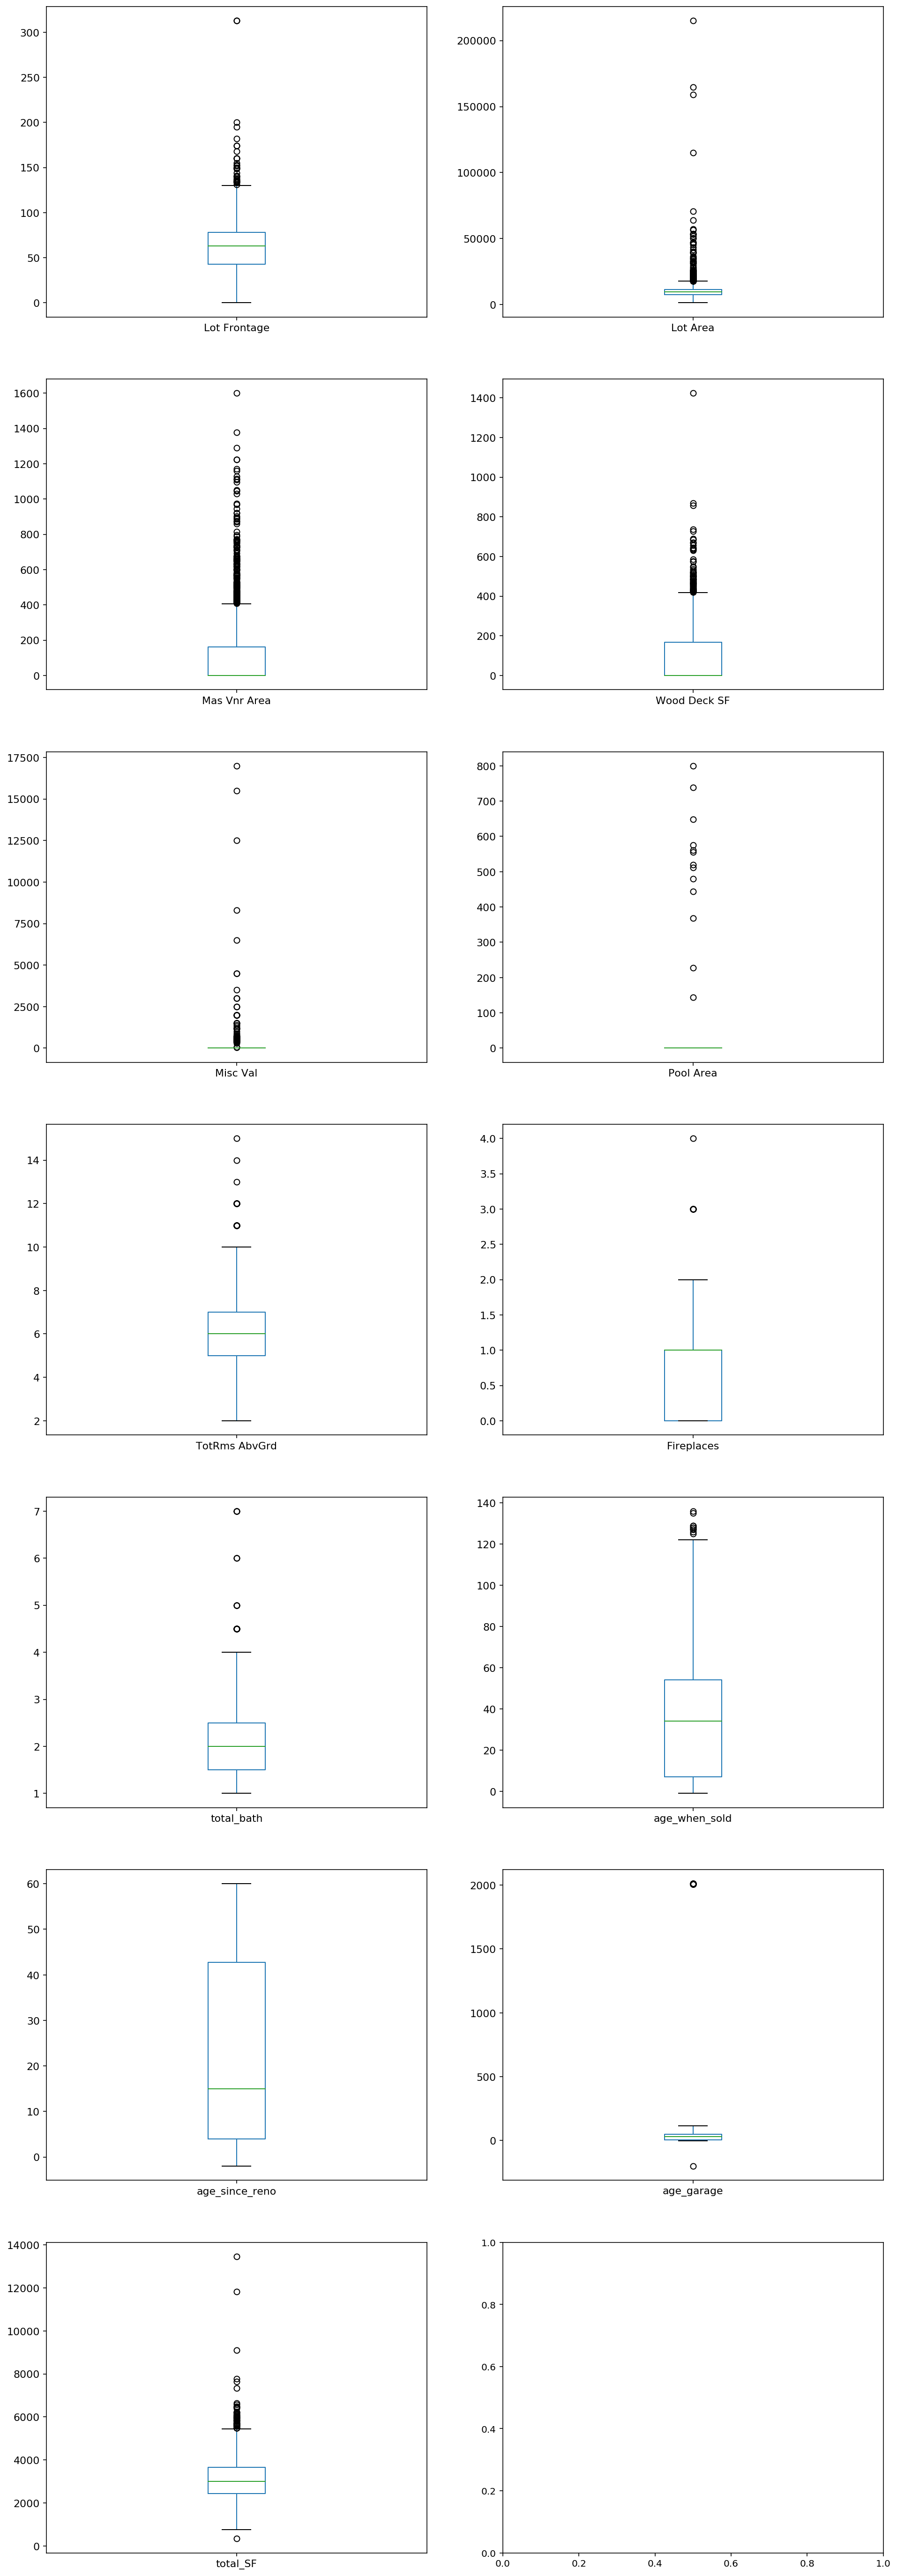

In [32]:
#boxplot for only continous variables and DV
fig, axes = plt.subplots(7,2, figsize=(16,50))

ames['Lot Frontage'].plot(kind="box", fontsize=11, ax=axes[0][0])
ames['Lot Area'].plot(kind="box", fontsize=11, ax=axes[0][1])
ames['Mas Vnr Area'].plot(kind="box", fontsize=11, ax=axes[1][0])
ames['Wood Deck SF'].plot(kind="box", fontsize=11, ax=axes[1][1])
ames['Pool Area'].plot(kind="box", fontsize=11, ax=axes[2][1])
ames['Misc Val'].plot(kind="box", fontsize=11, ax=axes[2][0])
ames['TotRms AbvGrd'].plot(kind="box", fontsize=11, ax=axes[3][0])
ames['Fireplaces'].plot(kind="box", fontsize=11, ax=axes[3][1])
ames['total_bath'].plot(kind="box", fontsize=11, ax=axes[4][0])
ames['age_when_sold'].plot(kind="box", fontsize=11, ax=axes[4][1])
ames['age_since_reno'].plot(kind="box", fontsize=11, ax=axes[5][0])
ames['age_garage'].plot(kind="box", fontsize=11, ax=axes[5][1])
ames['total_SF'].plot(kind="box", fontsize=11, ax=axes[6][0])




Boxplots were plotted on continuous variables. Visually, Lot frontage, lot area, totrms abvgrd, total SF seem to be normally distributed with many outliers. The other variables are skewed. Pool area and Misc Val have medians at 0. 

In [33]:
#this are the index of outliers and how many outliers there are. outliers = +/3sd
#for conti & discrete var

for col in conti_var:
    sd = np.std(ames[col],ddof=1)
    m = np.mean(ames[col])
    fo= sd*3 + m
    
    a= np.where(np.abs(ames[col])>fo)
    
    print(col, " =\n ", a)
    print("how many = ", np.count_nonzero(a))
    print("-------------------------------------------------------------")
    


Lot Frontage  =
  (array([ 441,  960, 1224, 1263, 1335, 1875, 2222, 2286, 2316, 2720, 2922],
      dtype=int64),)
how many =  11
-------------------------------------------------------------
Lot Area  =
  (array([  24,  108,  441,  471,  616,  694,  745,  823,  841,  960, 1052,
       1167, 1542, 1571, 1726, 1843, 1854, 1875, 1885, 1964, 2127, 2167,
       2265, 2358, 2392, 2418, 2574, 2767, 2921], dtype=int64),)
how many =  29
-------------------------------------------------------------
Mas Vnr Area  =
  (array([  71,   81,  108,  125,  138,  178,  199,  230,  257,  281,  359,
        378,  473,  480,  489,  623,  682,  800,  839,  960,  987, 1117,
       1151, 1170, 1227, 1230, 1254, 1409, 1416, 1420, 1581, 1592, 1604,
       1647, 1671, 1692, 1700, 1737, 1835, 1885, 1936, 1964, 1977, 2041,
       2127, 2131, 2140, 2155, 2167, 2172, 2173, 2281, 2284, 2289, 2309,
       2311, 2382, 2425, 2467, 2515, 2603, 2687, 2773], dtype=int64),)
how many =  63
------------------------------------

Outliers are identified in continuous variables. There are quite a few outliers in this dataset, based on the 3SD rule of thumb. However, ames might be an area where there are super big houses and houses that are very small. In a normal distribution, about 99.7% should be in within the +/- 3SD range. However, we cannot simply remove them as it is possible that the disparity between huge houses and average size houses is large. The range of outliers a variable have ranges from 6 to 159.

In [34]:
conti_var.append("SalePrice")


In [35]:
conti_var

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'Wood Deck SF',
 'Pool Area',
 'Misc Val',
 'TotRms AbvGrd',
 'Fireplaces',
 'total_bath',
 'age_when_sold',
 'age_since_reno',
 'age_garage',
 'total_SF',
 'SalePrice']

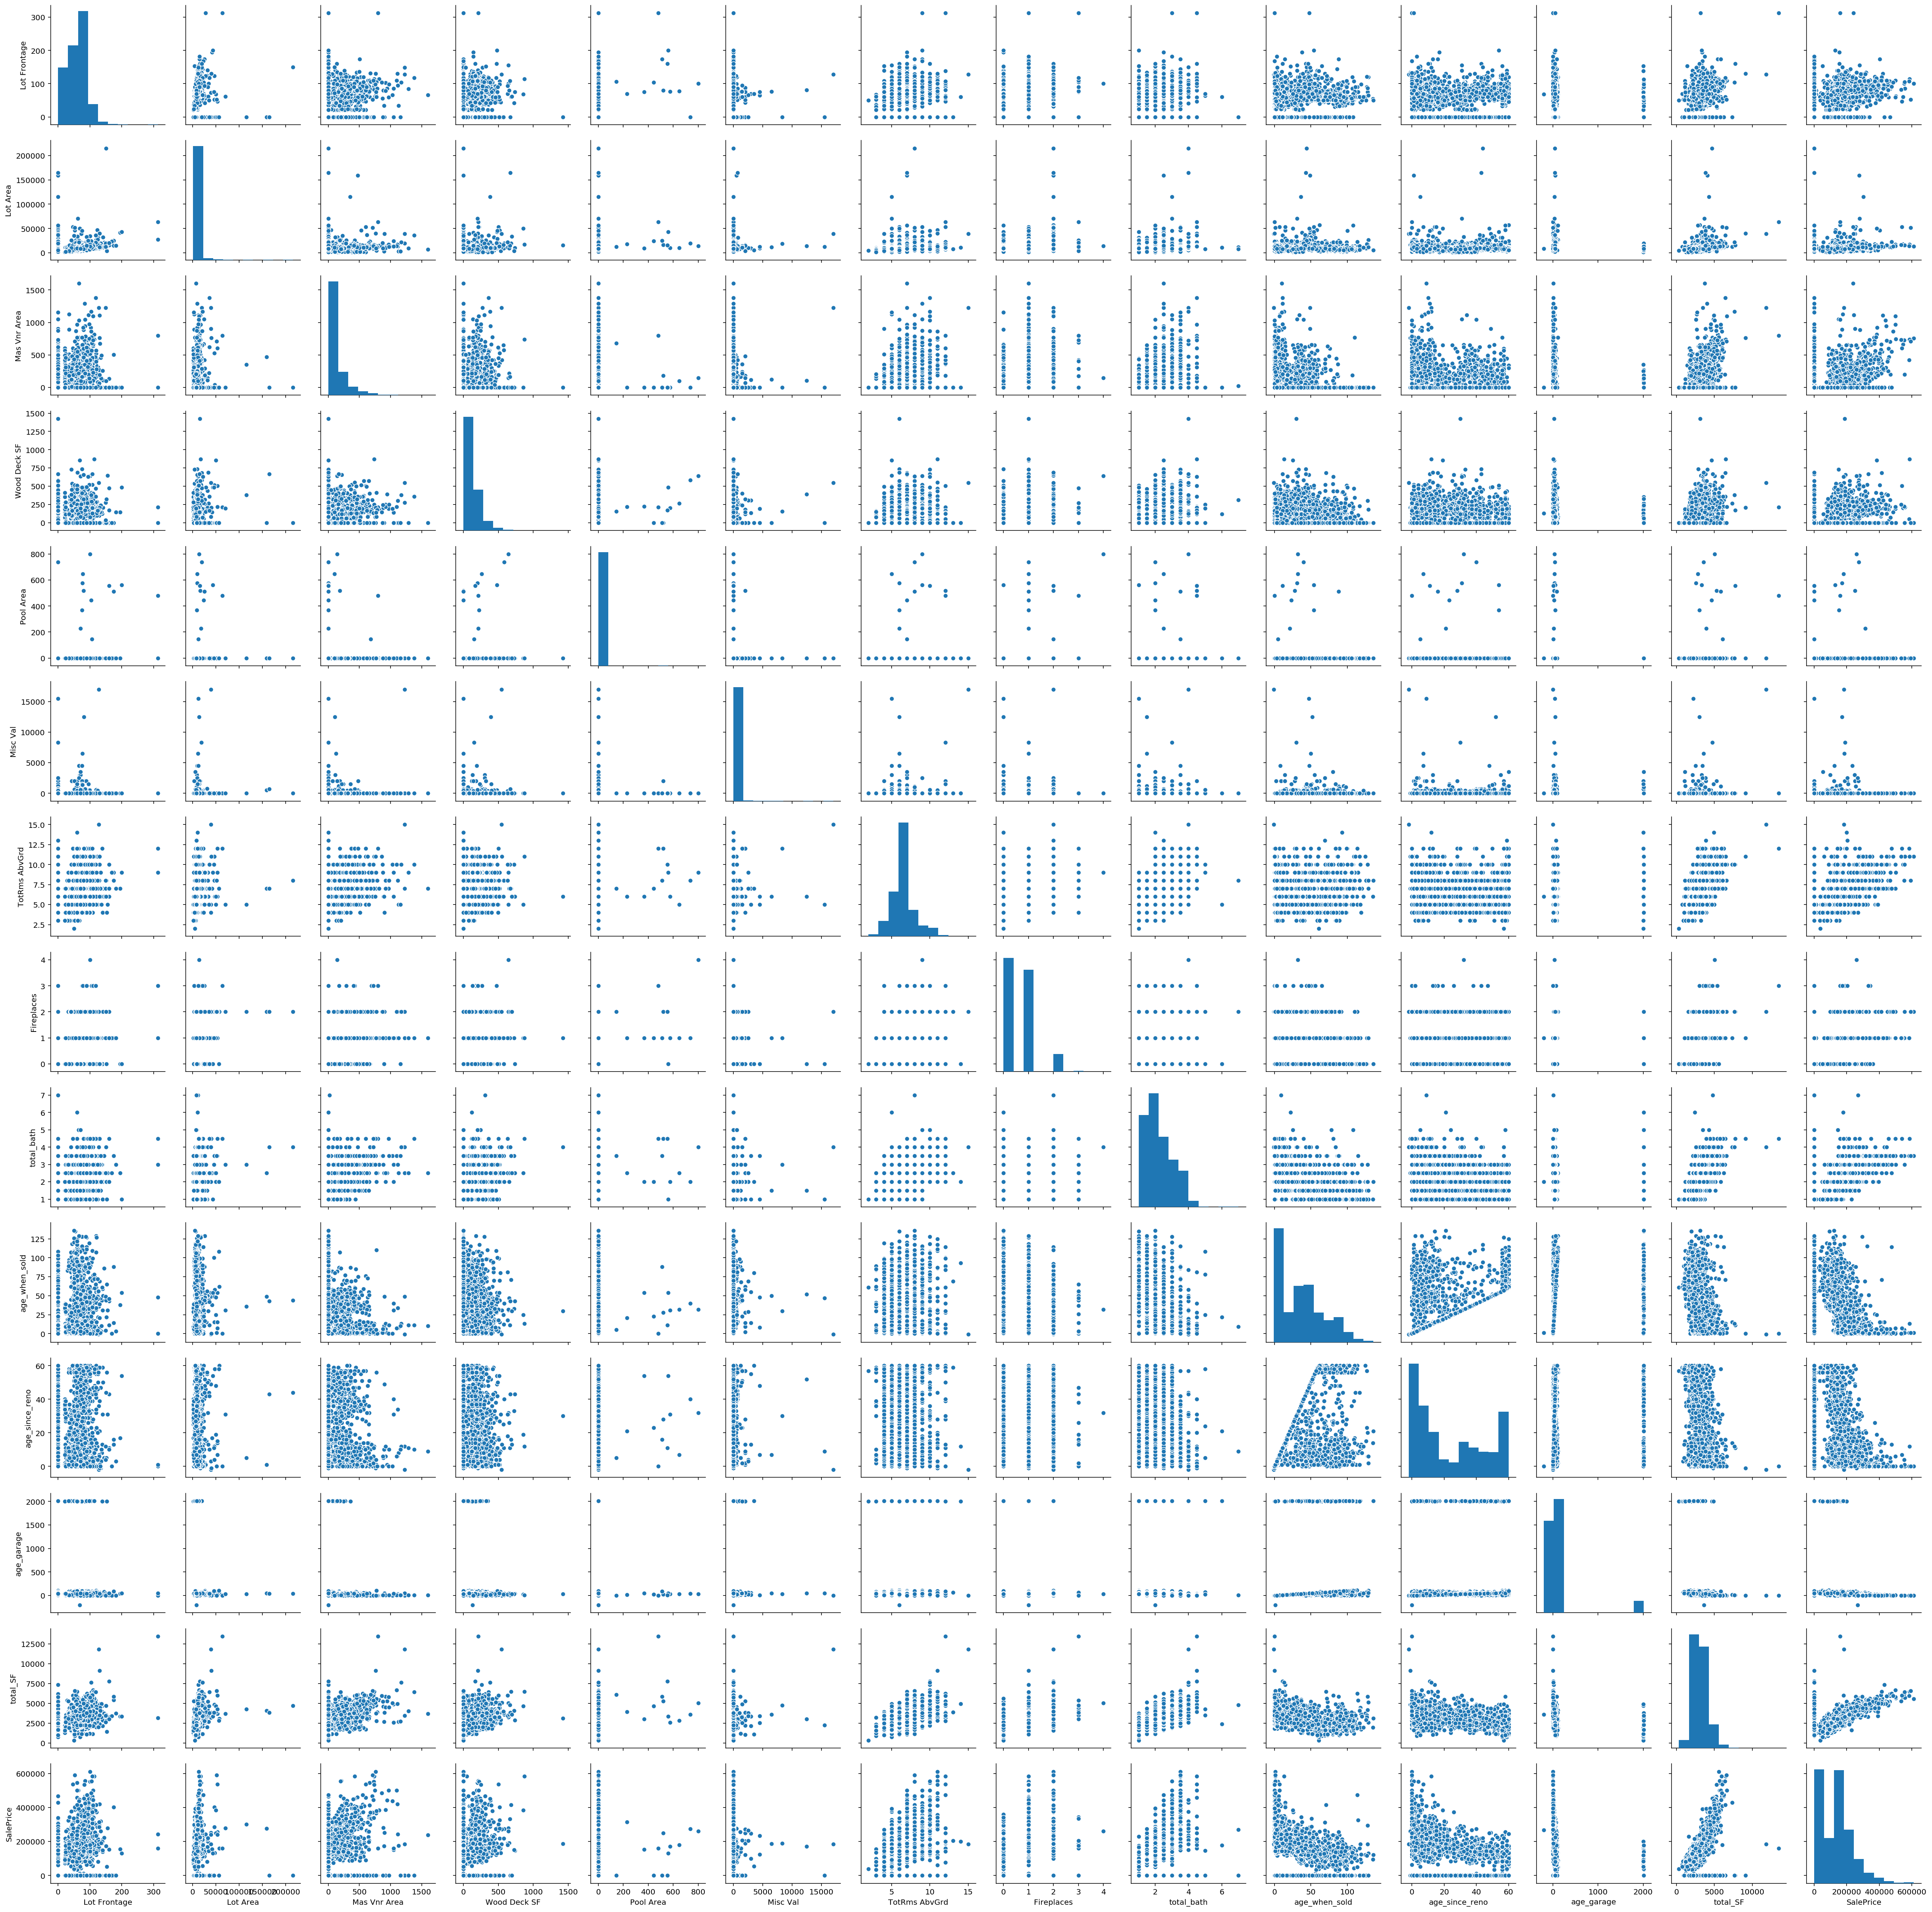

In [36]:
#pairplots for only continous/discr variables and DV
ax=sns.pairplot(ames[conti_var]) 

Pairplots were plotted for continuous, discrete and ordinal variables. 

Pairplots seem to show TotRms AbvGrd, Garage area, Gr liv area as possible normal distributions. The other variables are highly skewed or discrete. SalePrice (DV, dependent variable) is positively skewed. I will log transform the DV to make DV more normally distributed. 

We see some variables correlating with each other, as above. The IV's seem to fit a linear combination of the DV except total_SF, age_when_sold. 

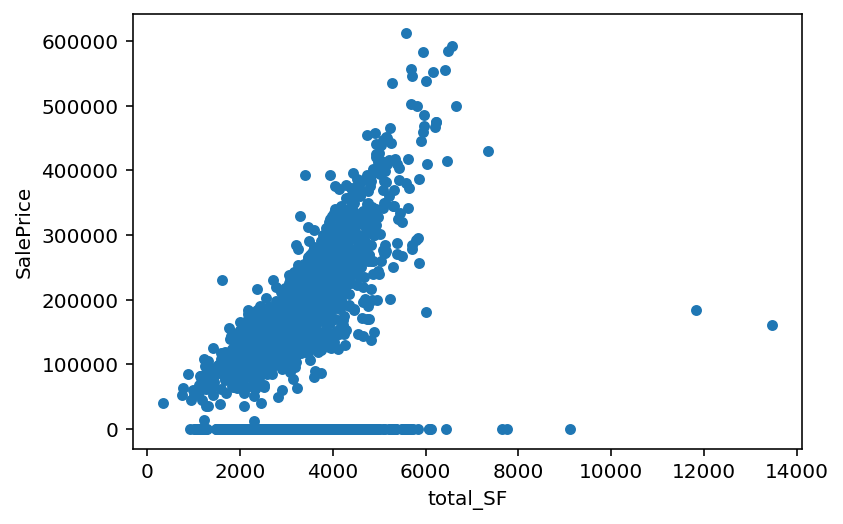

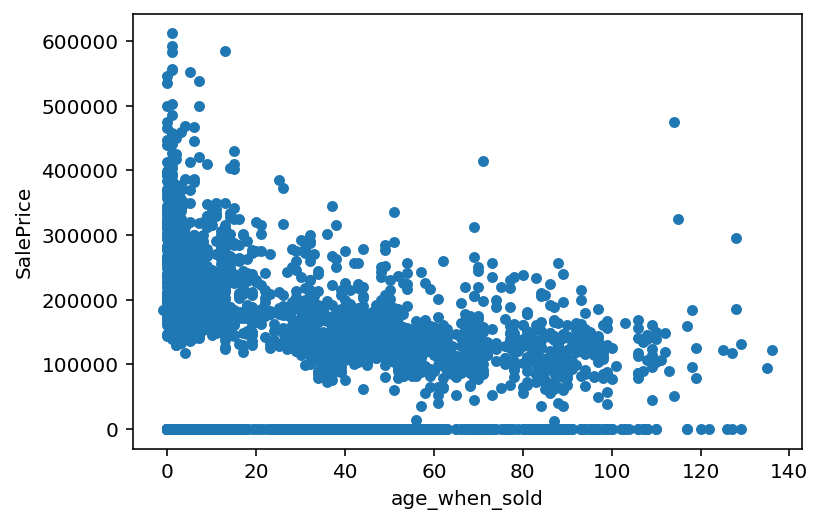

In [37]:
#seem to be quadratic 
ames.plot(x="total_SF", y="SalePrice", kind="scatter")
ames.plot(x='age_when_sold', y="SalePrice", kind="scatter")



In [38]:
#create a quadratic term for total_sf
ames['total_SF_sq']= ames['total_SF']*ames['total_SF']
ames['age_when_sold_sq']= ames['age_when_sold']*ames['age_when_sold']



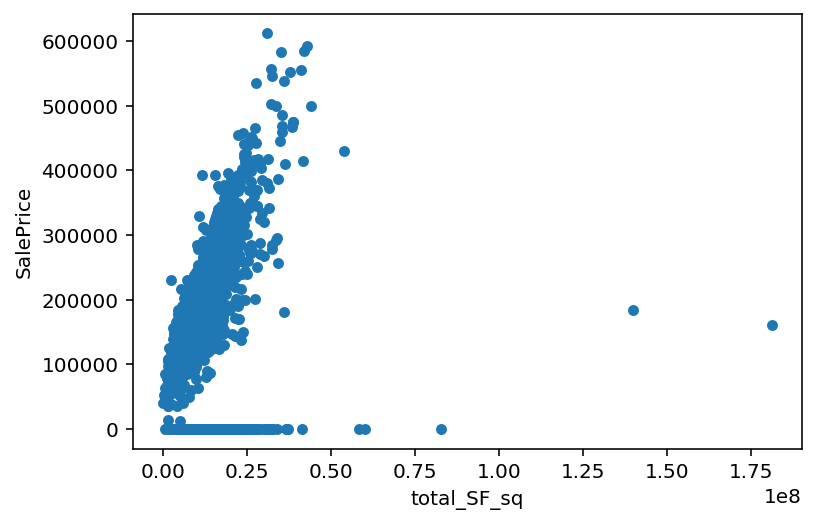

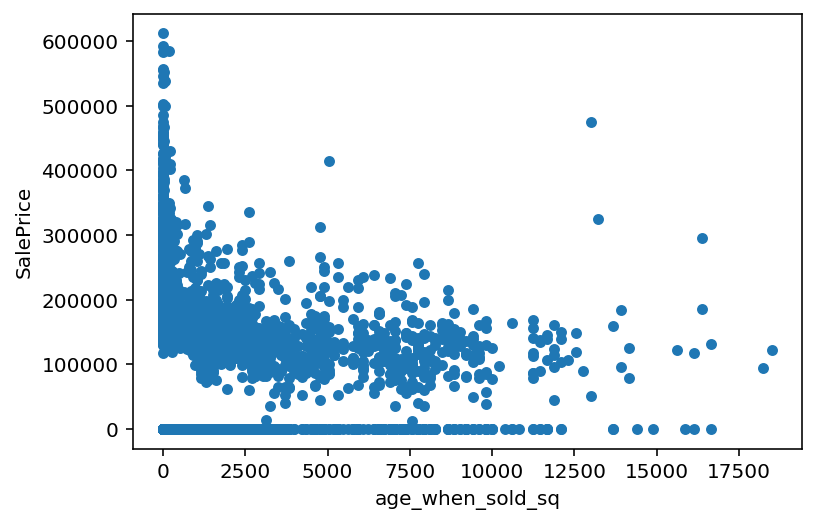

In [39]:
#looks like a function of saleprice

ames.plot(x="total_SF_sq", y="SalePrice", kind="scatter")
ames.plot(x='age_when_sold_sq', y="SalePrice", kind="scatter")


In [40]:
#append to list 

conti_var.append("total_SF_sq")
conti_var.append("age_when_sold_sq")

conti_var

['Lot Frontage',
 'Lot Area',
 'Mas Vnr Area',
 'Wood Deck SF',
 'Pool Area',
 'Misc Val',
 'TotRms AbvGrd',
 'Fireplaces',
 'total_bath',
 'age_when_sold',
 'age_since_reno',
 'age_garage',
 'total_SF',
 'SalePrice',
 'total_SF_sq',
 'age_when_sold_sq']

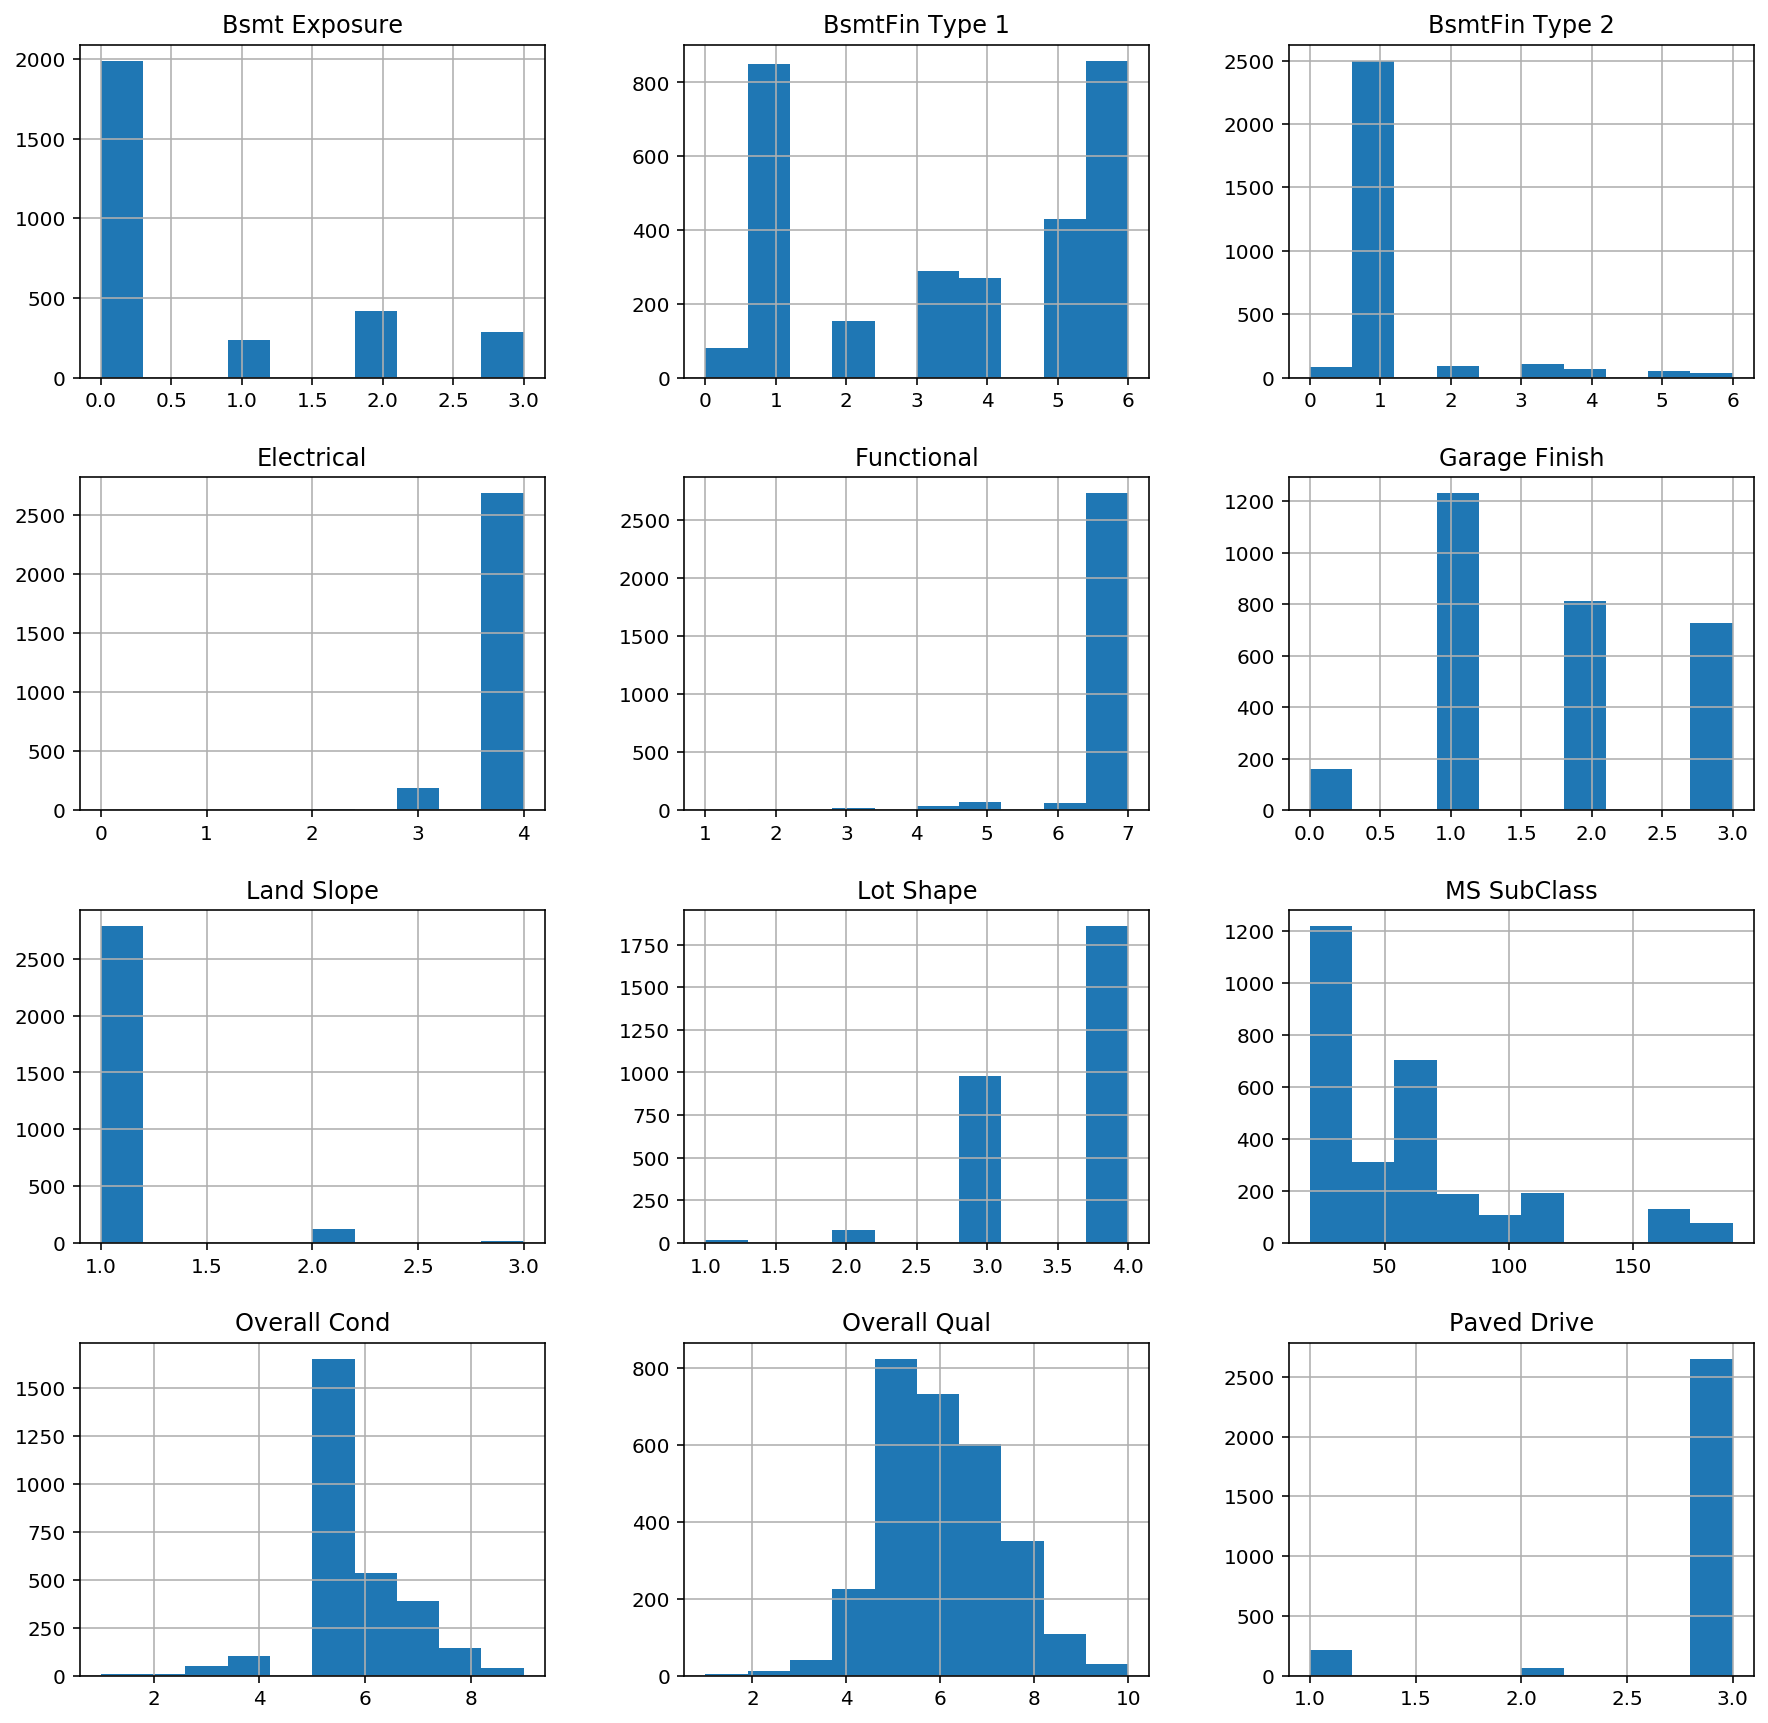

In [41]:
#hist plots of all the ordinal var 
#No point plotting discrete and ordinal data out as it will just look like distinct lines. 
ames[ord_var].hist(figsize=(15,15));

Historgrams were plotted for all ordinal variables. 

Most of the variables have no clear pattern of distribution, Some variables have a skewed distribution. The vriable "Overall Qual" looks like a normal distribution. 



In [42]:
#take all the conti variables and concat them into a new df 


ames_conti_combine = pd.concat([ames[ord_var], ames[conti_var]], axis=1)
ames_conti_combine.head()

Lot Shape  Land Slope  Bsmt Exposure  BsmtFin Type 1  BsmtFin Type 2  \
0          3           1              0               6               1   
1          3           1              0               6               1   
2          4           1              0               6               1   
3          4           1              0               1               1   
4          3           1              0               1               1   

   Electrical  Functional  Garage Finish  Paved Drive  Overall Cond  ...  \
0         4.0         7.0              2            3             8  ...   
1         4.0         7.0              2            3             5  ...   
2         4.0         7.0              1            3             7  ...   
3         4.0         7.0              3            3             5  ...   
4         4.0         7.0              1            1             8  ...   

   TotRms AbvGrd  Fireplaces  total_bath  age_when_sold  age_since_reno  \
0              6           0         2.5             34               5   
1              8           1         3.5             13              12   
2              5           0         2.0             57               3   
3              7           0         2.5              4               3   
4              6           0         2.0            110              17   

   age_garage  total_SF  SalePrice  total_SF_sq  age_when_sold_sq  
0        34.0    2723.0   130500.0    7414729.0              1156  
1        12.0    3668.0   220000.0   13454224.0               169  
2        57.0    2412.0   109000.0    5817744.0              3249  
3         3.0    2228.0   174000.0    4963984.0                16  
4        53.0    2664.0   138500.0    7096896.0             12100  

[5 rows x 28 columns]

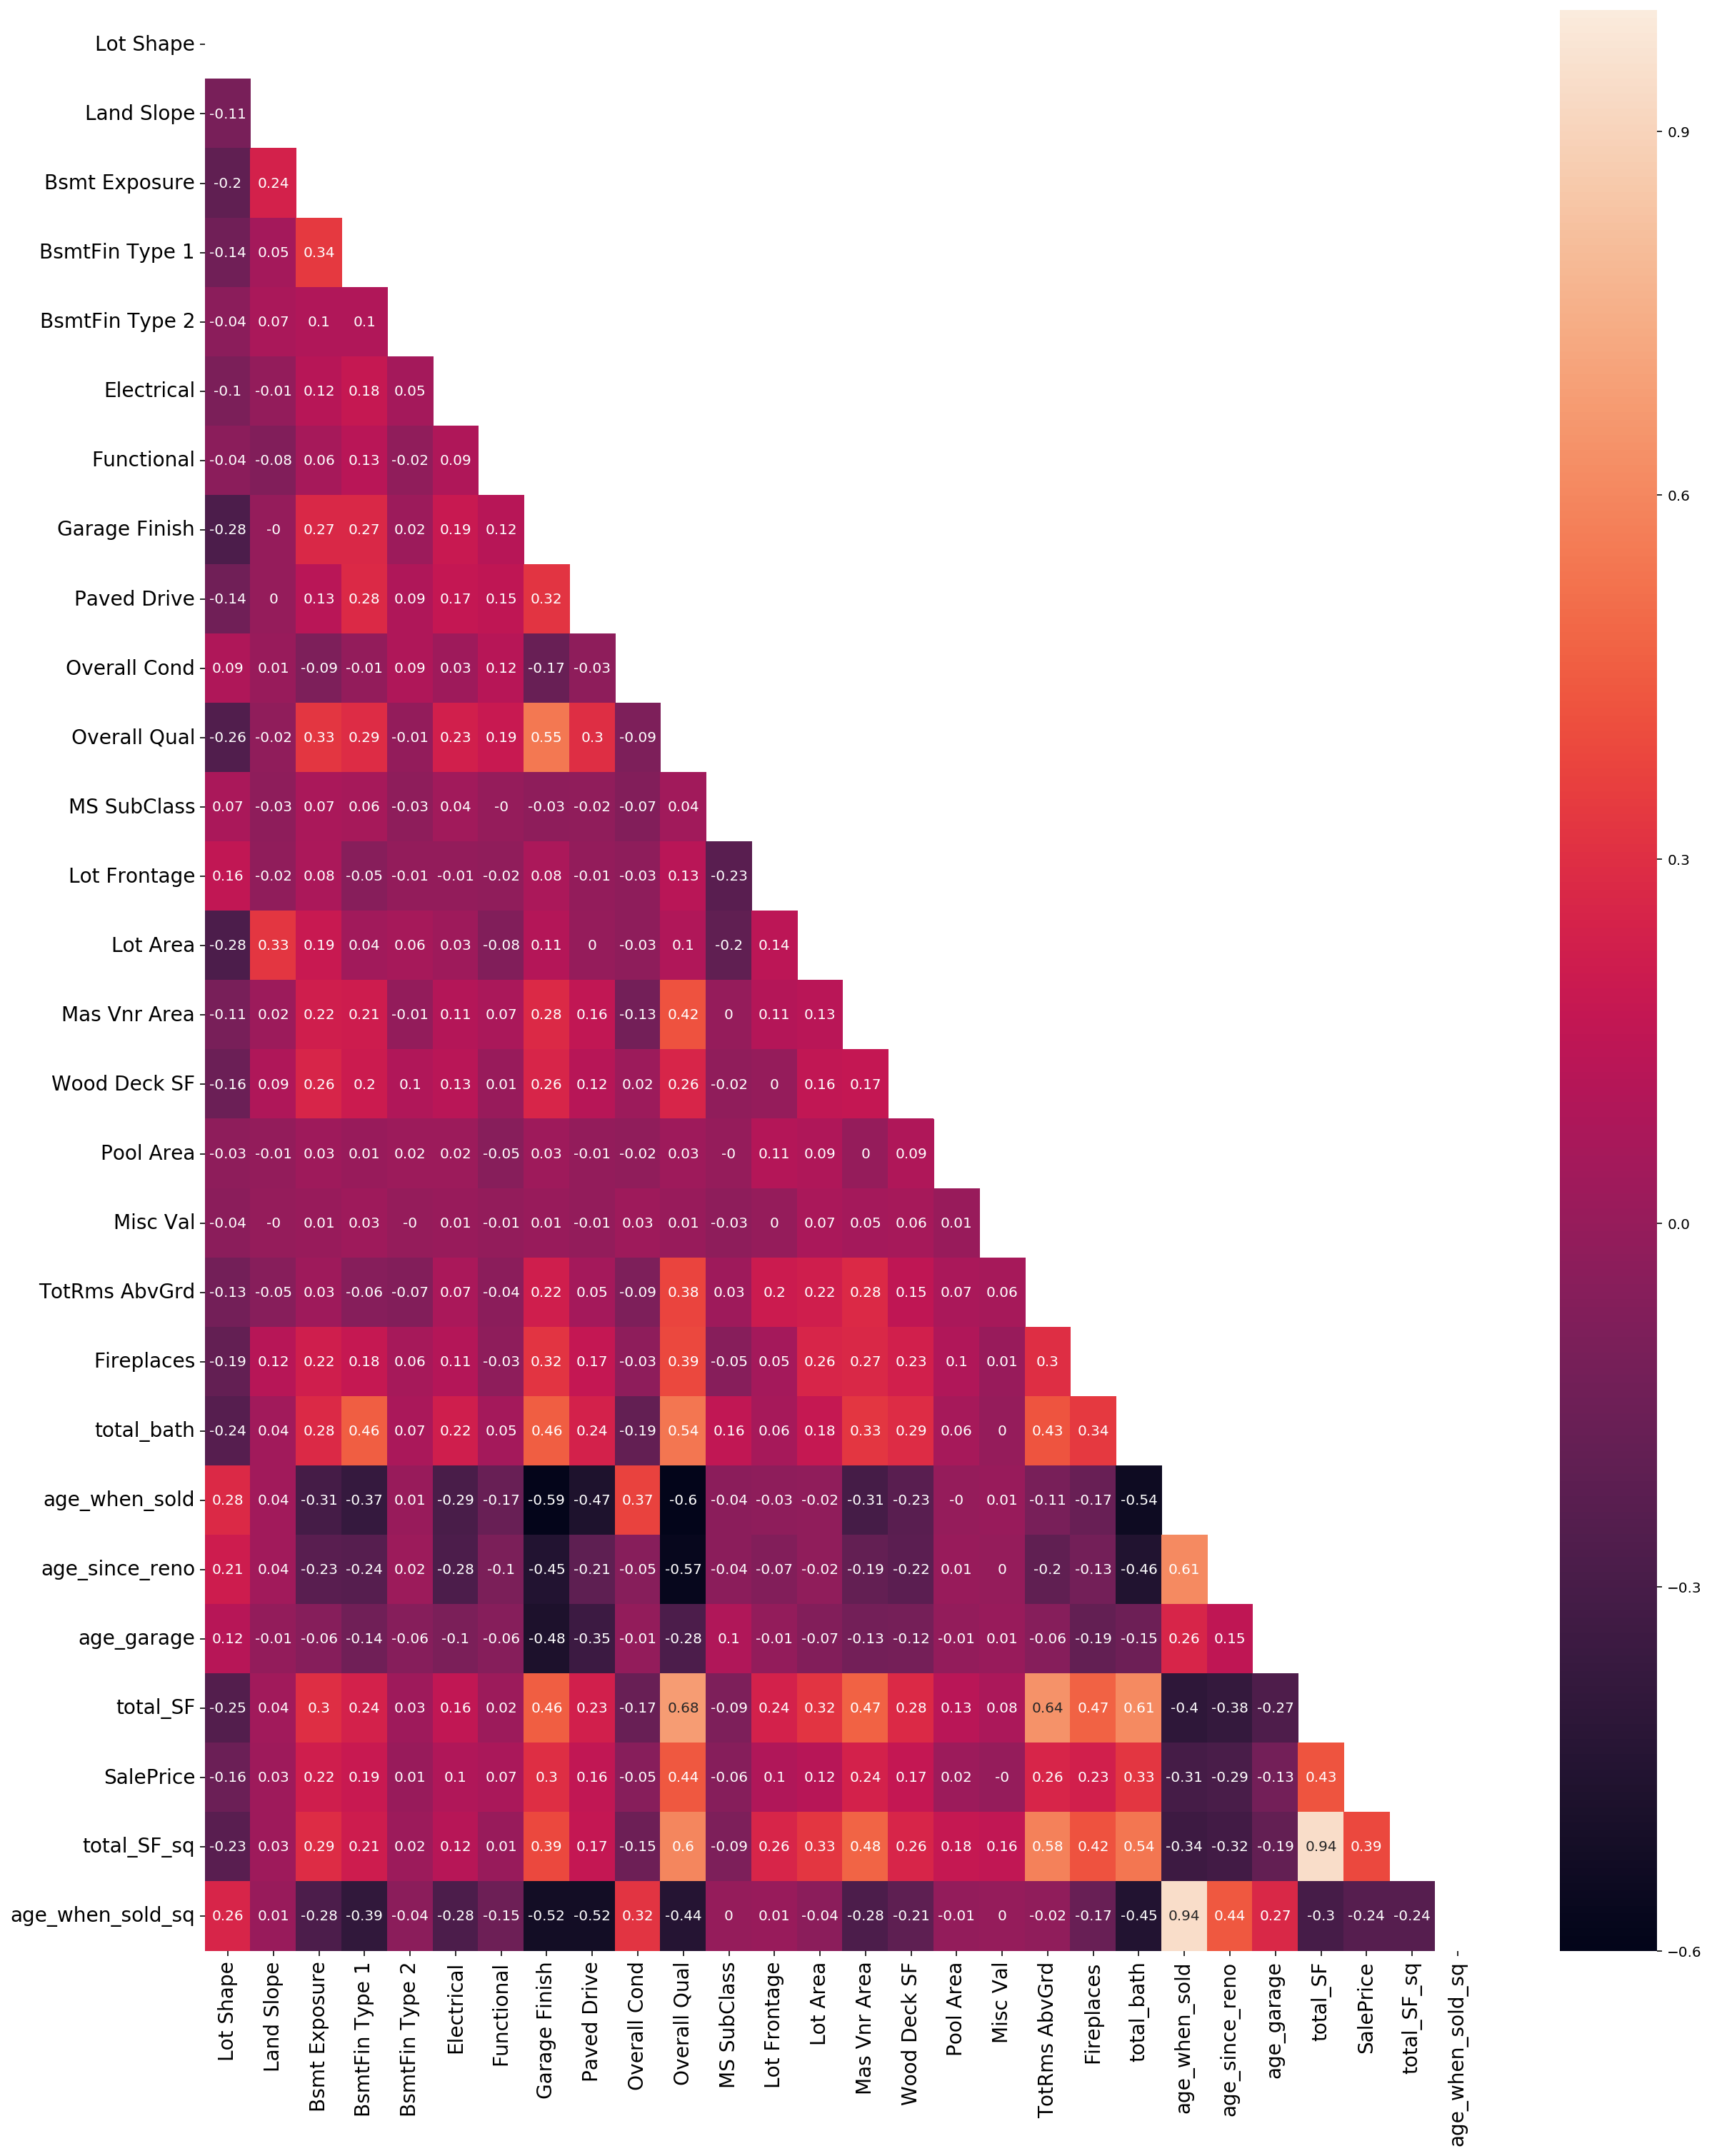

In [43]:

ames_conti_corr=round(ames_conti_combine.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(20,25))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(ames_conti_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(ames_conti_corr,mask=mask, ax=ax, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, va="center")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top -0.5)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

Heatmap was plotted for continuous, discrete and ordinal variables.

Overall, there are some variables correlaing strongly with each other such as Garage finish and age_when_sold. There are also variables that have zero correlations with each other when rounded to 2 decimal places such as Misc Val and Lot frontage. 

At a glance, it doesnt seem like there are stong correlations to the DV. 


There is a total of 28 Continuous, Discrete, Ordinal variables.

**Ordinal** data was identified. Value counts were conducted on them and Utilities was dropped as it had only 2 and 1 responses for NoSewr and NoSewa. After that, ordinal variables were coded  larger number represents more of a desired quality. Example, Lot Shape was coded from 1 to 4 with 1 being the most irregular and 4 being regular. Variables that contain responses indicating an absence of a feature will have 0 coded for absence. After coding them, i made sure they were integers or floats. 

**Continuous** Boxplots were plotted on continuous variables. Visually, Lot frontage, lot area, totrms abvgrd, total SF seem to be normally distributed with many outliers. The other variables are skewed. Pool area and Misc Val have medians at 0. 

**Outliers** are identified in continuous variables. There are quite a lot outliers in this dataset, based on the 3SD rule of thumb. However, it might possible that there are super big houses and houses that are very small. In a normal distribution, about 99.7% should be in within the +/- 3SD range. However, we cannot simply remove them as it is possible that the disparity between huge houses and average size houses is large. The range of outliers a variable have ranges from as little as 6 in age_when_sold to 159 in age_garage.

**Pairplots of the continuous, discrete and ordinal variables and the dependent variable (DV), SalePrice, was plotted.** Pairplots seem to show TotRms AbvGrd, Garage area, Gr liv area as possible normal distributions. The other variables are highly skewed or discrete. SalePrice (DV, dependent variable) is positively skewed. I will log transform the DV to make DV more normally distributed in later parts of the analysis. We see some variables correlating with each other but not strongly. The IV's seem to fit a linear combination of the DV except total_SF, age_when_sold.

Total_SF, age_when_sold seem to have a quadratic function to the DV. Thus, I included quadratic terms for them. 

**Correlations** Heatmap was plotted for continuous, discrete and ordinal variables. Overall, there are some variables correlaing strongly with each other such as Garage finish and age_when_sold. There are also variables that have zero correlations with each other when rounded to 2 decimal places such as Misc Val and Lot frontage. At a glance, it doesnt seem like there are stong correlations to the DV. No IVs seem to correlate more than a magnitude of 0.5 with the DV. 


### Exploring Norminal/Binary variables 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

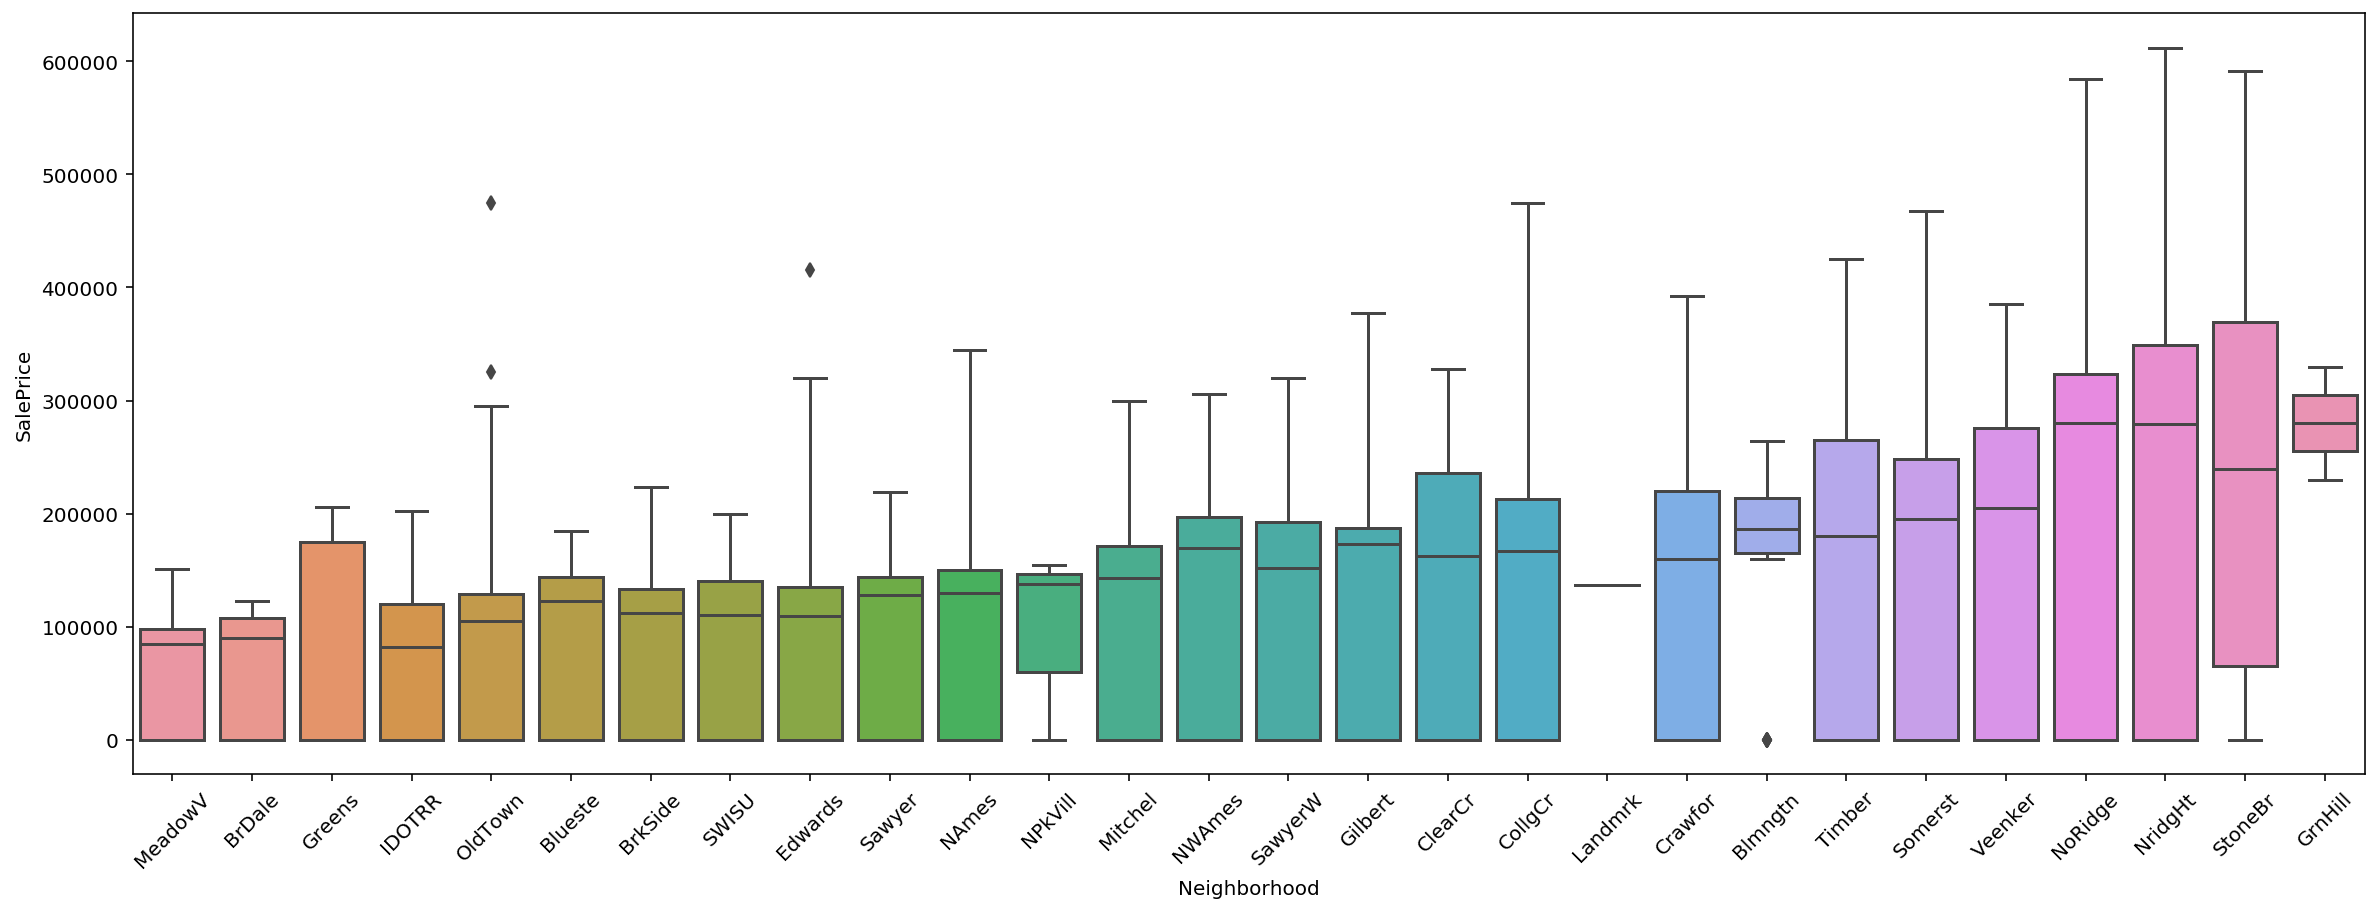

In [44]:
#addtional exploration
my_order = ames.groupby(by=['Neighborhood'])["SalePrice"].mean().sort_values().index

plt.figure(figsize=(20, 7))
sns.boxplot(x='Neighborhood', y='SalePrice', data=ames, order= my_order)
plt.xticks(rotation=45)

In [45]:
#list of all norminal/binary var

nb_var=['House Style', 'Lot Config', 'Street','Heating', 
        'Foundation', 'Land Contour', 'Condition 1',
        'Condition 2','Roof Style', 'Neighborhood', 
        'MS Zoning','Exterior 1st', 'Exterior 2nd', 
        'Central Air','Mas Vnr Type', 'Sale Type',
        'Bldg Type', 'Roof Matl', 'Garage Type']

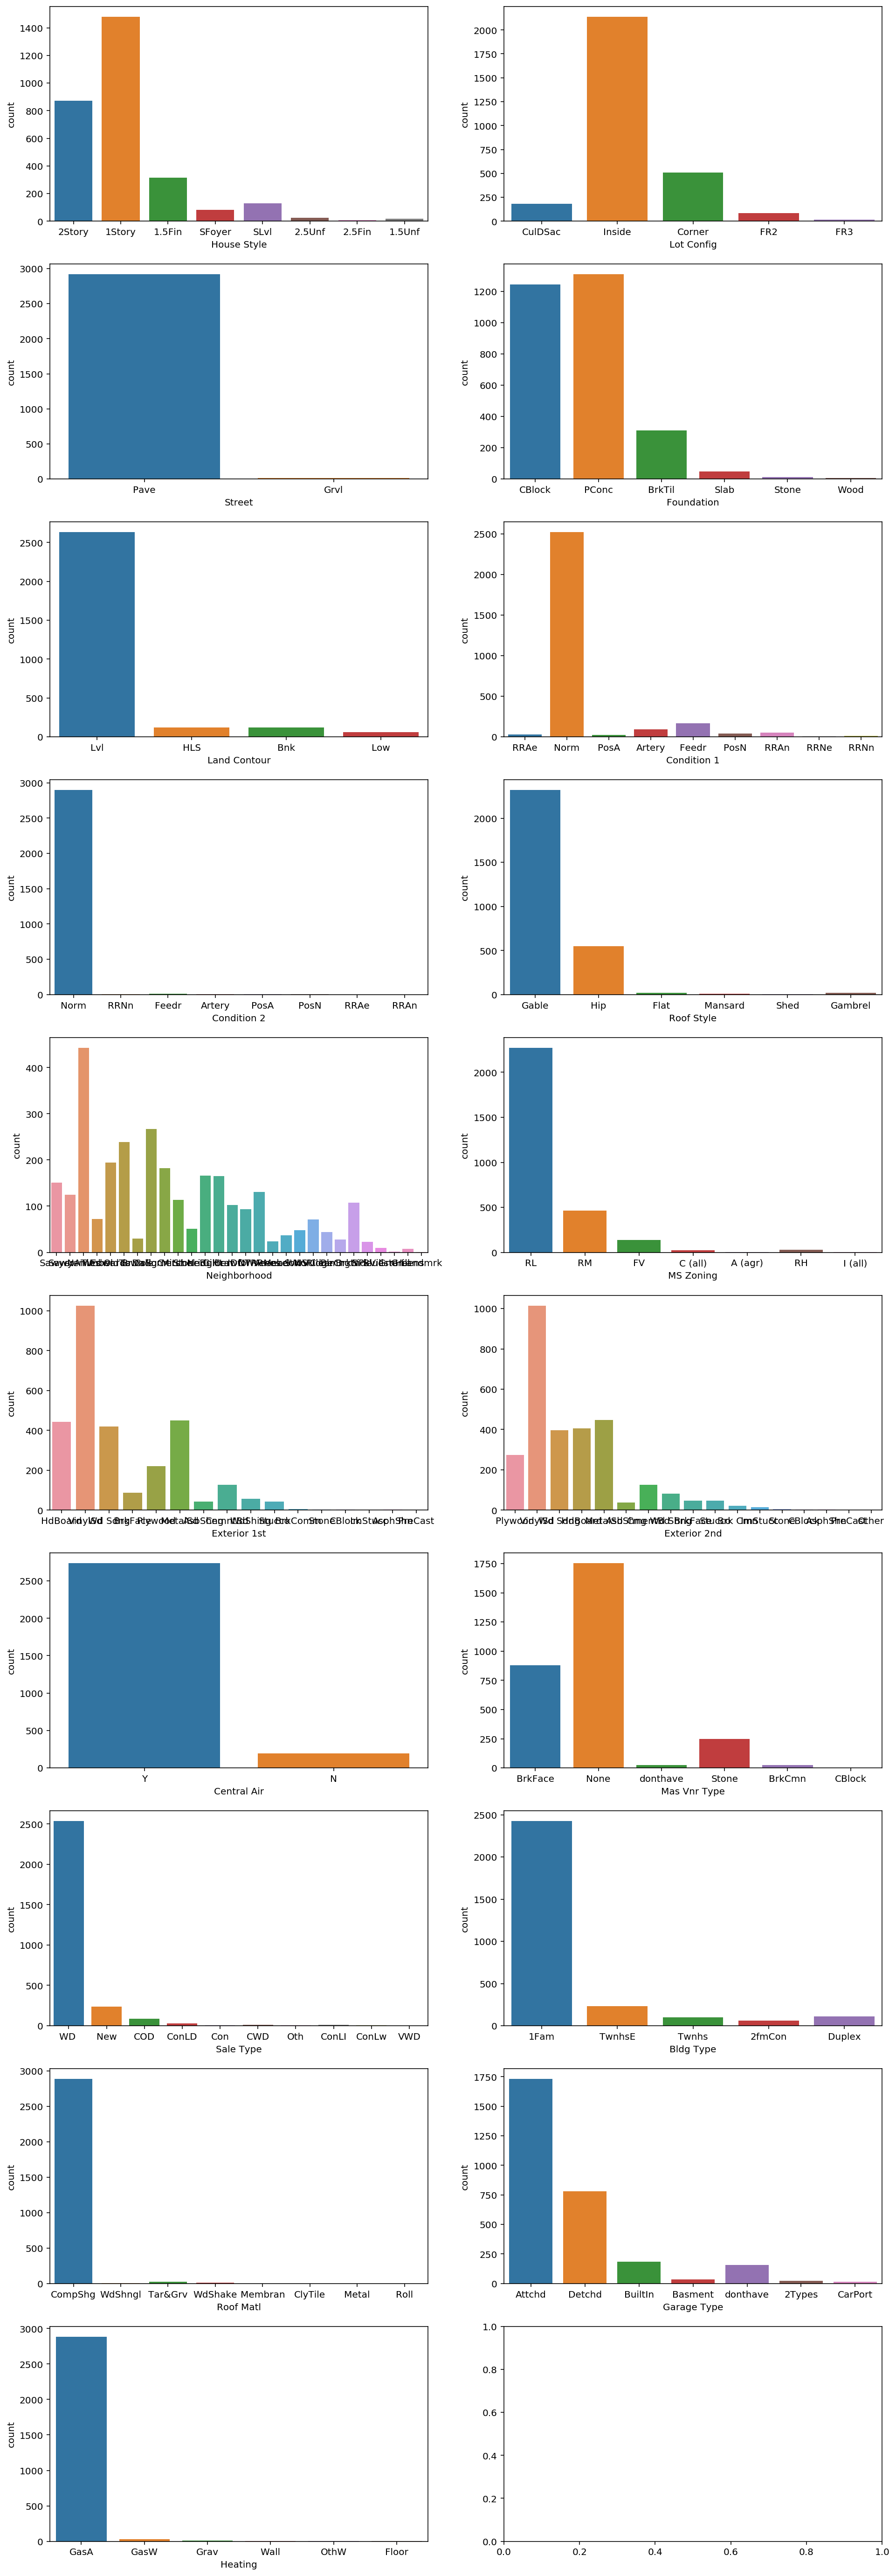

In [46]:
#freq dist of norm/bi var

fig, axes = plt.subplots(10,2, figsize=(16,50))

sns.countplot(data = ames, x = 'House Style', ax=axes[0][0])
sns.countplot(data = ames, x = 'Lot Config', ax=axes[0][1])
sns.countplot(data = ames, x = 'Street', ax=axes[1][0])
sns.countplot(data = ames, x = 'Foundation', ax=axes[1][1])
sns.countplot(data = ames, x = 'Land Contour', ax=axes[2][0])
sns.countplot(data = ames, x = 'Condition 1', ax=axes[2][1])
sns.countplot(data = ames, x = 'Condition 2', ax=axes[3][0])
sns.countplot(data = ames, x = 'Roof Style', ax=axes[3][1])
sns.countplot(data = ames, x = 'Neighborhood', ax=axes[4][0])
sns.countplot(data = ames, x = 'MS Zoning', ax=axes[4][1])
sns.countplot(data = ames, x = 'Exterior 1st', ax=axes[5][0])
sns.countplot(data = ames, x = 'Exterior 2nd', ax=axes[5][1])
sns.countplot(data = ames, x = 'Central Air', ax=axes[6][0])
sns.countplot(data = ames, x = 'Mas Vnr Type', ax=axes[6][1])
sns.countplot(data = ames, x = 'Sale Type', ax=axes[7][0])
sns.countplot(data = ames, x = 'Bldg Type', ax=axes[7][1])
sns.countplot(data = ames, x = 'Roof Matl', ax=axes[8][0])
sns.countplot(data = ames, x = 'Garage Type', ax=axes[8][1])
sns.countplot(data = ames, x = 'Heating', ax=axes[9][0])



The frequency plots of all norminal and binary variables show us the count of each values in the variable. 
We can certainly see that some features within the variables are more popular than others. 
For instance, in House Style, 1story is the most popular. 


Some of the variables have very few counts in some categories. For instance, Street which have 2043 Pave but only 7 in Grvl. This makes the variable useless as the disparity between categories are too large. Some features such as mansory is very rare and have a lot more people who do not have it than have it will also be dropped. These variables will be dropped: Street, Condition 2,  Roof Matl. 

In [47]:
ames.drop(["Street", "Condition 2", "Roof Matl"], axis=1, inplace=True)


In [48]:
ames.shape

(2930, 47)

In [49]:
remove = "Street", "Condition 2", "Roof Matl"
for i in remove:
    nb_var.remove(i)
    
nb_var

['House Style',
 'Lot Config',
 'Heating',
 'Foundation',
 'Land Contour',
 'Condition 1',
 'Roof Style',
 'Neighborhood',
 'MS Zoning',
 'Exterior 1st',
 'Exterior 2nd',
 'Central Air',
 'Mas Vnr Type',
 'Sale Type',
 'Bldg Type',
 'Garage Type']

In [50]:
#get dummies for norm/bi var

dummy_df = pd.get_dummies(ames[nb_var], drop_first=True)
(list(dummy_df.columns))


['House Style_1.5Unf',
 'House Style_1Story',
 'House Style_2.5Fin',
 'House Style_2.5Unf',
 'House Style_2Story',
 'House Style_SFoyer',
 'House Style_SLvl',
 'Lot Config_CulDSac',
 'Lot Config_FR2',
 'Lot Config_FR3',
 'Lot Config_Inside',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Land Contour_HLS',
 'Land Contour_Low',
 'Land Contour_Lvl',
 'Condition 1_Feedr',
 'Condition 1_Norm',
 'Condition 1_PosA',
 'Condition 1_PosN',
 'Condition 1_RRAe',
 'Condition 1_RRAn',
 'Condition 1_RRNe',
 'Condition 1_RRNn',
 'Roof Style_Gable',
 'Roof Style_Gambrel',
 'Roof Style_Hip',
 'Roof Style_Mansard',
 'Roof Style_Shed',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_Greens',
 'Neighb

In [51]:
ames.drop(nb_var, axis=1, inplace=True)

In [52]:
ames_with_dummy = pd.concat([ames, dummy_df])

In [53]:
for col in ames_with_dummy:
    if ames_with_dummy[col].dtype == "int64" or "float64":
        ames_with_dummy[col].fillna(value=0, inplace=True)
    else:
        pass

In [54]:
ames_with_dummy.head()

Id          PID  MS SubClass  Lot Frontage  Lot Area  Lot Shape  \
0  109.0  533352170.0         60.0           0.0   13517.0        3.0   
1  544.0  531379050.0         60.0          43.0   11492.0        3.0   
2  153.0  535304180.0         20.0          68.0    7922.0        4.0   
3  318.0  916386060.0         60.0          73.0    9802.0        4.0   
4  255.0  906425045.0         50.0          82.0   14235.0        3.0   

   Land Slope  Overall Qual  Overall Cond  Mas Vnr Area  ...  \
0         1.0           6.0           8.0         289.0  ...   
1         1.0           7.0           5.0         132.0  ...   
2         1.0           5.0           7.0           0.0  ...   
3         1.0           5.0           5.0           0.0  ...   
4         1.0           6.0           8.0           0.0  ...   

   Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  Bldg Type_TwnhsE  \
0               0.0               0.0              0.0               0.0   
1               0.0               0.0              0.0               0.0   
2               0.0               0.0              0.0               0.0   
3               0.0               0.0              0.0               0.0   
4               0.0               0.0              0.0               0.0   

   Garage Type_Attchd  Garage Type_Basment  Garage Type_BuiltIn  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   Garage Type_CarPort  Garage Type_Detchd  Garage Type_donthave  
0                  0.0                 0.0                   0.0  
1                  0.0                 0.0                   0.0  
2                  0.0                 0.0                   0.0  
3                  0.0                 0.0                   0.0  
4                  0.0                 0.0                   0.0  

[5 rows x 157 columns]



There is a total of 16 norminal and binary variables. 

**Histograms of counts were plotted for norminal and binary variables.** At an instance, we can see some features/category within the variables are more popular than others. For instance, in House Style, 1story is the most popular. Some of the variables have very few counts in their respective categories. For instance, Street which have 2043 Pave but only 7 in Grvl. This renders the variable useless as the disparity between categories are too large. Some features such as mansory is very rare and have a lot more people who do not have it than have it will also be dropped. These variables are dropped: Street, Condition 2, Roof Matl.


**Dummy coding** The remaining variables were dummy coded, dropping the first of each. This means that a 0 for all the dummy coded variable of a variable will represent the column that has been dropped. Thus, each variable has n-1 columns of dummy coded variables, where n is the number of unique responses for that variables. This is the number of values that are free to vary (degree of freedom) for each variable. The parent variable was dropped from the dataset while the dummy coded variables were added in. 



## Preprocessing

In [55]:
train_df = ames_with_dummy[ames_with_dummy['data_from']=='train']
final_test_df = ames_with_dummy[ames_with_dummy['data_from']=='test']


In [56]:
train_df.head()

Id          PID  MS SubClass  Lot Frontage  Lot Area  Lot Shape  \
0  109.0  533352170.0         60.0           0.0   13517.0        3.0   
1  544.0  531379050.0         60.0          43.0   11492.0        3.0   
2  153.0  535304180.0         20.0          68.0    7922.0        4.0   
3  318.0  916386060.0         60.0          73.0    9802.0        4.0   
4  255.0  906425045.0         50.0          82.0   14235.0        3.0   

   Land Slope  Overall Qual  Overall Cond  Mas Vnr Area  ...  \
0         1.0           6.0           8.0         289.0  ...   
1         1.0           7.0           5.0         132.0  ...   
2         1.0           5.0           7.0           0.0  ...   
3         1.0           5.0           5.0           0.0  ...   
4         1.0           6.0           8.0           0.0  ...   

   Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  Bldg Type_TwnhsE  \
0               0.0               0.0              0.0               0.0   
1               0.0               0.0              0.0               0.0   
2               0.0               0.0              0.0               0.0   
3               0.0               0.0              0.0               0.0   
4               0.0               0.0              0.0               0.0   

   Garage Type_Attchd  Garage Type_Basment  Garage Type_BuiltIn  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   Garage Type_CarPort  Garage Type_Detchd  Garage Type_donthave  
0                  0.0                 0.0                   0.0  
1                  0.0                 0.0                   0.0  
2                  0.0                 0.0                   0.0  
3                  0.0                 0.0                   0.0  
4                  0.0                 0.0                   0.0  

[5 rows x 157 columns]

In [57]:
train_df.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   2051.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     57.944417   10065.208191   
std     843.980841  1.886918e+08    42.824223     33.137332    6742.488909   
min       1.000000  5.263011e+08    20.000000      0.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     43.500000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     63.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     78.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

         Lot Shape   Land Slope  Overall Qual  Overall Cond  Mas Vnr Area  \
count  2051.000000  2051.000000   2051.000000   2051.000000   2051.000000   
mean      3.595807     1.052657      6.112140      5.562165     98.626524   
std       0.566514     0.244264      1.426271      1.104497    174.324690   
min       1.000000     1.000000      1.000000      1.000000      0.000000   
25%       3.000000     1.000000      5.000000      5.000000      0.000000   
50%       4.000000     1.000000      6.000000      5.000000      0.000000   
75%       4.000000     1.000000      7.000000      6.000000    159.000000   
max       4.000000     3.000000     10.000000      9.000000   1600.000000   

       ...  Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  \
count  ...            2051.0            2051.0           2051.0   
mean   ...               0.0               0.0              0.0   
std    ...               0.0               0.0              0.0   
min    ...               0.0               0.0              0.0   
25%    ...               0.0               0.0              0.0   
50%    ...               0.0               0.0              0.0   
75%    ...               0.0               0.0              0.0   
max    ...               0.0               0.0              0.0   

       Bldg Type_TwnhsE  Garage Type_Attchd  Garage Type_Basment  \
count            2051.0              2051.0               2051.0   
mean                0.0                 0.0                  0.0   
std                 0.0                 0.0                  0.0   
min                 0.0                 0.0                  0.0   
25%                 0.0                 0.0                  0.0   
50%                 0.0                 0.0                  0.0   
75%                 0.0                 0.0                  0.0   
max                 0.0                 0.0                  0.0   

       Garage Type_BuiltIn  Garage Type_CarPort  Garage Type_Detchd  \
count               2051.0               2051.0              2051.0   
mean                   0.0                  0.0                 0.0   
std                    0.0                  0.0                 0.0   
min                    0.0                  0.0                 0.0   
25%                    0.0                  0.0                 0.0   
50%                    0.0                  0.0                 0.0   
75%                    0.0                  0.0                 0.0   
max                    0.0                  0.0                 0.0   

       Garage Type_donthave  
count                2051.0  
mean                    0.0  
std                     0.0  
min                     0.0  
25%                     0.0  
50%                     0.0  
75%                     0.0  
max                     0.0  

[8 rows x 156 columns]

In [58]:
ivs = list(train_df.columns)

remove_iv = 'Id','PID','SalePrice', 'data_from'
for i in remove_iv:
    ivs.remove(i)
  

In [59]:
#choose x, y 
#log of price

X=train_df[ivs]
y=np.log(train_df["SalePrice"])

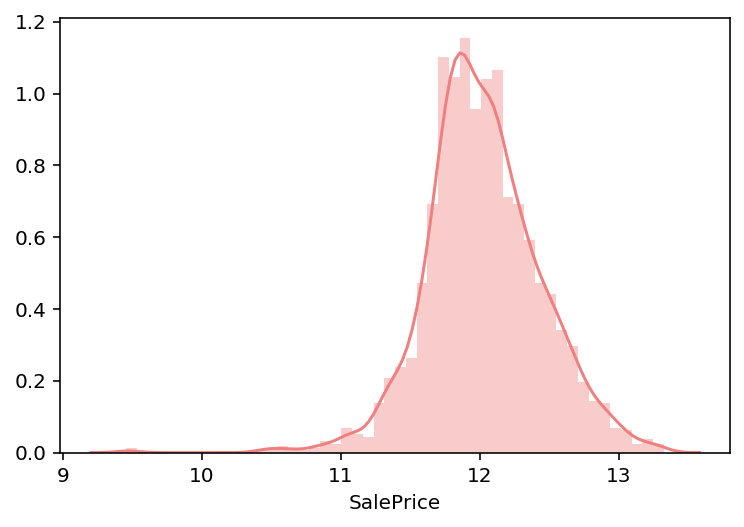

In [60]:
#plt.hist(np.log(train_df["SalePrice"]), color="pink");

ax=sns.distplot(np.log(train_df["SalePrice"]), color="lightcoral")

In [61]:
#perform train test split and evaluate

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)  


Using the identifier, we **split the data back to its original source** (training and holdout set). The **DV is now log transformed** to give it a more normal distribution to correct for its positve skew. This will not affect the test set as the test set does not have any DV provided. A **train-test split** was performed on the training data. 80% of the data was splitted for training while 20% was reserved for testing the model developed. 

## Multiple regression

In [62]:
#baseline model
naive_df= pd.DataFrame(y_test)
naive_df['naivepred']=np.mean(y_test)

In [63]:
# MSE baseline
mean_squared_error(np.exp(y_test), np.exp(naive_df['naivepred']))

6164201301.636075

In [64]:
#RMSE baseline
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(naive_df['naivepred'])))

78512.42768909948

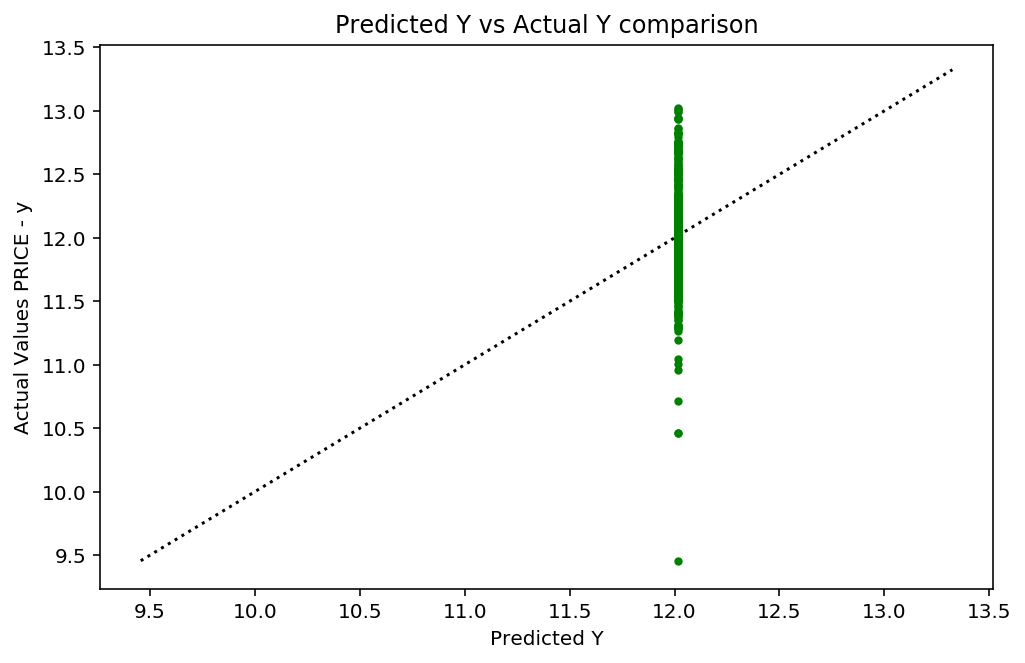

In [65]:
# Plot the model, how well are we predicting 

plt.figure(figsize=(8,5))
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], ':', c = 'k')
plt.scatter(naive_df['naivepred'], y_test, s=10, c='g', zorder=10)
plt.xlabel("Predicted Y")
plt.title('Predicted Y vs Actual Y comparison')
plt.ylabel("Actual Values PRICE - y")


plt.show()

The plots comparing a baseline model and the actual sale price is plotted. Plots show that the model is poor in predicting sale price and have a high bias. 

In [66]:
lr = LinearRegression()

In [67]:
#fit into linear regression and get r2 score

lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8985033321143472

In [68]:
#MSE lr train
lr_pred_train= lr.predict(X_train)
mean_squared_error(np.exp(y_train), np.exp(lr_pred_train))

636032987.9070785

In [69]:
#RMSE
np.sqrt(mean_squared_error(np.exp(y_train), np.exp(lr_pred_train)))

25219.694445156914

In [70]:
#R2
lr.score(X_test, y_test)

0.8689467822712698

In [71]:
#MSE lr test

lr_pred= lr.predict(X_test)
mean_squared_error(np.exp(y_test), np.exp(lr_pred))

882939532.2960296

In [72]:
#RMSE lr test
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lr_pred)))

29714.298448659858

In [73]:
#using cross_val_score to see how the model does

kf=KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_score(lr, X, y, cv= kf).mean()

0.8833866395677583

In [74]:
lr_mean_mse=-cross_val_score(lr, X_train, np.exp(y_train), cv= kf, scoring='neg_mean_squared_error' ).mean()
lr_mean_mse

1443336301.4952402

In [75]:
np.sqrt(lr_mean_mse)

37991.266121244764

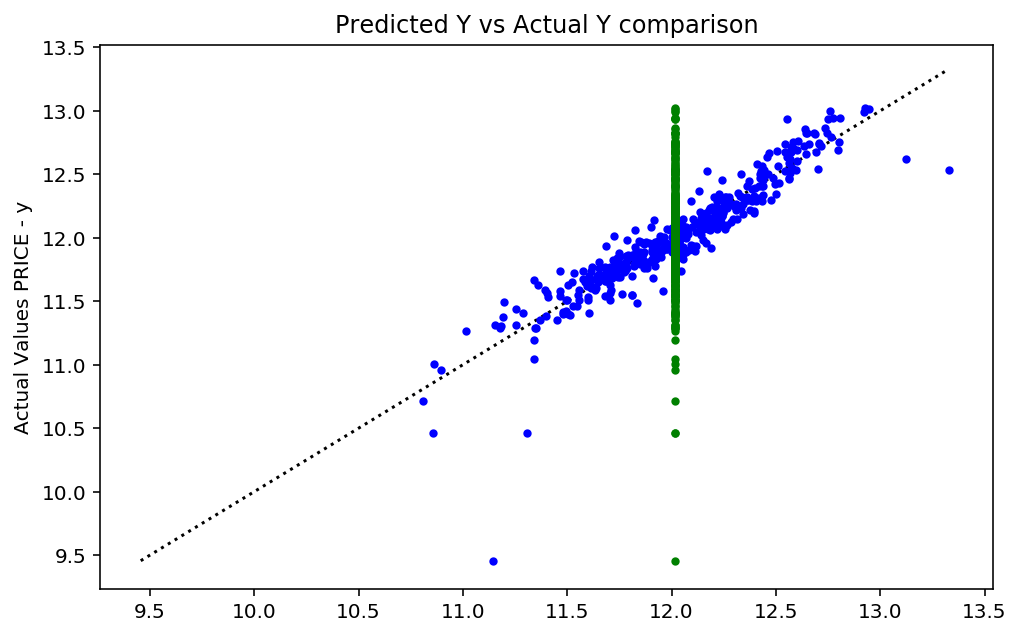

In [76]:
# Plot the model, how well are we predicting 

plt.figure(figsize=(8,5))
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], ':', c = 'k')
plt.scatter(lr_pred, y_test, s=10, c='b', zorder=10)
plt.scatter(naive_df['naivepred'], y_test, s=10, c='g', zorder=10)
plt.title('Predicted Y vs Actual Y comparison')
plt.ylabel("Actual Values PRICE - y")


plt.show()

The train set was fitted into a linear regression and a R2 score of 0.899 was obtain. This means that our model was able to explain 89.9% of the variance in sale price, within the training set. When the fitted model was used to score the test set, it yeild an R2 of 0.869, a drop of about 0.03. A 10 fold Cross validation was performed with a mean R2 score of 0.883. The cross validation's mean of root mean square value (RMSE) 37,991.26. Compared to a baseline model with a MSE of 0.1802 and a RMSE of 0.4245, calculated by the mean of sale price, this is a stark improvement in prediction scores as it reflect that our model predicted sale price is closer to the test set's sale price. 

The bias of this model is very low with a relatively moderate variance. However, due to the large amount of variables, there is still a risk of overfitting. We want to perform a type of regularization where the data values to reduce multicolinearity and more importantly, overfitting. This works by increase the sum of square errors, much like introducing some "bias" into the model so that it performs better in a real prediction.  

Actual prices of the test set was plotted against its predicted. The scatter plots show that the predicted and actual sale price is highly accurate as it follows closely on a 45 degree diagonal line with minimal noise. 

## Lasso regression

In [77]:
#lasso is chosen because i want to eliminate features not jsut shrink them
#favor parsimony 
#Need to scale before lasso
#scale to Z dist


ss = StandardScaler()
ss.fit(X_train)

X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [78]:
%%time
#find the best alpha 
l_alphas = np.arange(0.001, 0.15, 0.0025)   

optimal_lasso = LassoCV(alphas=l_alphas, n_alphas=555, cv=10)
optimal_lasso.fit(X_train_sc, y_train)

print (optimal_lasso.alpha_)

0.001
Wall time: 531 ms


In [79]:
#put in the optimal alpha
#lasso train r2

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X_train_sc, y_train)
lasso.score(X_train_sc, y_train)

0.8978499875011565

In [80]:
#lasso mse train
ls_pred_train= lasso.predict(X_train_sc)
mean_squared_error(np.exp(y_train), np.exp(ls_pred_train))

644415247.7786664

In [81]:
#Lasso RMSE train
np.sqrt(mean_squared_error(np.exp(y_train), np.exp(ls_pred_train)))

25385.335289861083

In [82]:
#lasso r2 test
lasso.score(X_test_sc, y_test)

0.8702594859668141

In [83]:
#lasso mse test
ls_pred= lasso.predict(X_test_sc)
mean_squared_error(np.exp(y_test), np.exp(ls_pred))

819560631.941989

In [84]:
#lasso RMSE
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(ls_pred)))

28627.969399557296

In [85]:
#Lasso cross val score r2
cross_val_score(lasso, X_train_sc, np.exp(y_train), cv=10).mean()

0.7525830471462687

In [86]:
#cross val mean mse
lasso_mse=-cross_val_score(lasso, X_train_sc, np.exp(y_train), cv=10, scoring='neg_mean_squared_error').mean()
lasso_mse

1483243765.8287861

In [87]:
#cross val rmse
np.sqrt(lasso_mse)

38512.903887252985

In [88]:
#get the coefs and absolute value of coef and put them into a df and name the columns 
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})


In [89]:
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [90]:
#how many left after lasso regression

survivals = lasso_coefs[lasso_coefs["abs_coef"]>0]
survivals.head(25)

variable      coef  abs_coef
24        total_SF  0.307051  0.307051
25     total_SF_sq -0.192503  0.192503
5     Overall Qual  0.112680  0.112680
21   age_when_sold -0.055872  0.055872
6     Overall Cond  0.043300  0.043300
22  age_since_reno -0.034204  0.034204
2         Lot Area  0.031372  0.031372
20      total_bath  0.030080  0.030080
14      Fireplaces  0.029756  0.029756
12   TotRms AbvGrd  0.023521  0.023521
13      Functional  0.022147  0.022147
16     Paved Drive  0.019490  0.019490
9   BsmtFin Type 1  0.019373  0.019373
8    Bsmt Exposure  0.014859  0.014859
0      MS SubClass -0.013900  0.013900
7     Mas Vnr Area  0.009637  0.009637
15   Garage Finish  0.009334  0.009334
19        Misc Val -0.009055  0.009055
17    Wood Deck SF  0.005921  0.005921
1     Lot Frontage  0.005645  0.005645
4       Land Slope  0.004667  0.004667
3        Lot Shape -0.004595  0.004595
18       Pool Area -0.003362  0.003362
10  BsmtFin Type 2 -0.002029  0.002029
23      age_garage  0.001810  0.001810

In [91]:
#beta 0
lasso.intercept_

12.026237221066896

In [92]:
#Overall Cond
np.exp(0.043300)

1.044251123200971


**Lasso regression was the selected choice** to regularize the model due to its unique shrinkage. The procedure encoourages parsimony. It also helps to automate certain parts of model selection by applying a penalty. This more streamlined, more parsimonious model will likely perform better at predictions and will be better understood/interpretted by audience. It adds a penalty that is equal to the absolute value of the magnitude of the coefficients. As such, some coefficients may be eliminated which help us fulfil our goal of a parsimonious model. 

Prior to the Lasso regressions, **scaling of IVs** was performed. The training set was scaled by minusing its mean and dividing by its standard deviation to being it into a Z scale. The same scaling that was fitted into the training IVs was used on the testing IVs.

An **optimal alpha** was selected by 555 number of aphas along the regularization path from a list ranging 0.001 to 0.15. The optimal alpha of 0.001 was obtained and fitted into the Lasso regression with the training set. 

**Scores** for the training and test was calculated. The R2 score was 0.898 and 0.870 respectively. A 10 fold cross validation was performed, yeilding an R2 score of 0.883. The cross validation's mean of root mean square value (RMSE) 38,512.90. This is higher as Lasso introduces some bias that to the sum of squared errors that is equals to multiplication of alpha and the absolute slope of the regression line to reduce variance and overfitting. The high R2 scores tell us that our model is very low in bias. The difference in R2 scores between training to test and between training to crossvalidation scores tell us that our model have a fairly low variance and would likely generalize well on an unseen set of predictors. 

Compared to a baseline model with a RMSE of 78512.42, calculated by the mean of sale price, this is a stark improvement in prediction scores as it reflect that our model predicted sale price is closer to the test set's sale price.The Lasso regression scored slightly better than the multiple regression without regularization. However, the number of variables left was 25 from 153 previously, which shows that our final fitted model is five times more parsimonuous. 


**Comparison of model's accuracy scores**

|Baseline Model| test  |
|:-----------:|-------------|
|    MSE    |    6,164,201,301.63  |
|    RMSE   |    78,512.42   |

|     MR:   |    Train    |    Test    |    CV    |
|-----------|-------------|------------|----------|
| R2 scores | 0.899       | 0.869      | 0.883    |
|    MSE    | 636,032,987.90 | 882,939,532.29     | 1,443,336,301.90  |
|    RMSE   | 25,219.69   | 29,714.29     | 37,991.26   |

|   Lasso:  |    Train    |    Test    |    CV    |
|-----------|-------------|------------|----------|
| R2 scores | 0.898       | 0.870      | 0.883    |
|    MSE    |    644,415,247.77   | 819,560,631.94  | 1,483,243,765.82   |
|    RMSE    |    25,385.33   | 28,627.96     | 38,512.90   |

## Regression evaluation and diagnostics


In [93]:
eva_pred = lasso.predict(X_test_sc)

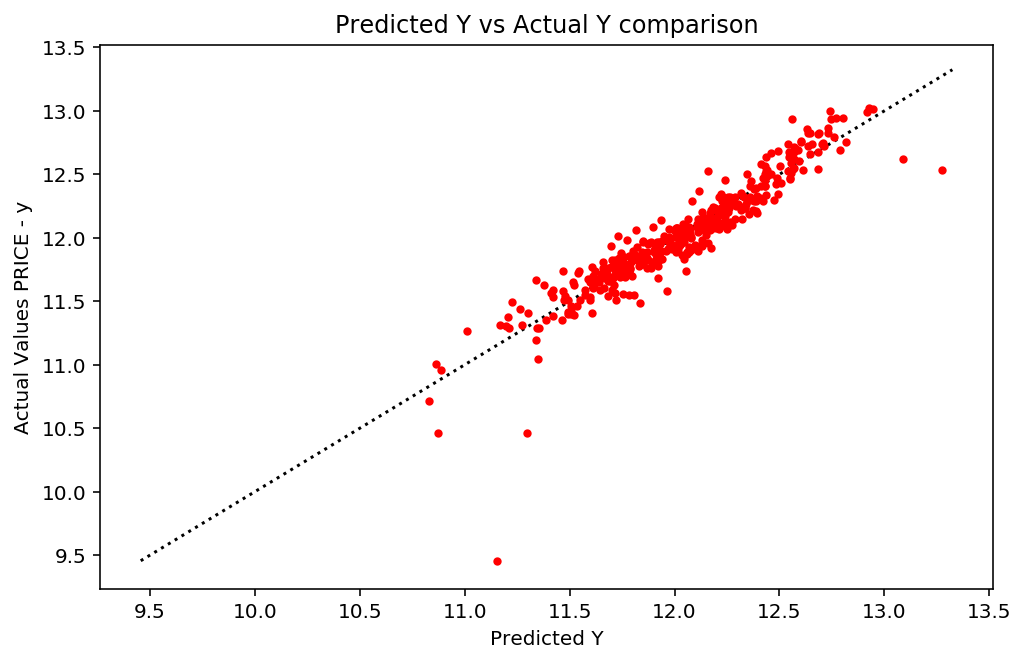

In [94]:
# Plot the model, how well are we predicting 

plt.figure(figsize=(8,5))
plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], ':', c = 'k')
plt.scatter(eva_pred, y_test, s=10, c='r', zorder=10)
plt.title('Predicted Y vs Actual Y comparison')
plt.xlabel("Predicted Y")
plt.ylabel("Actual Values PRICE - y")


plt.show()

Actual prices of the test set was plotted against its predicted. The scatter plots show that the predicted and actual sale price is highly accurate as it follows closely on a 45 degree diagonal line with minimal noise. The plots look exactly the same as before the Lasso regression, as expected from only a minimal increase in scores from the multiple regression and the Lasso regression. However, the Lasso model was used as it has significantly reduced the number of variables, allowing us a simplier model. 


In [95]:
residuals = y_test - eva_pred

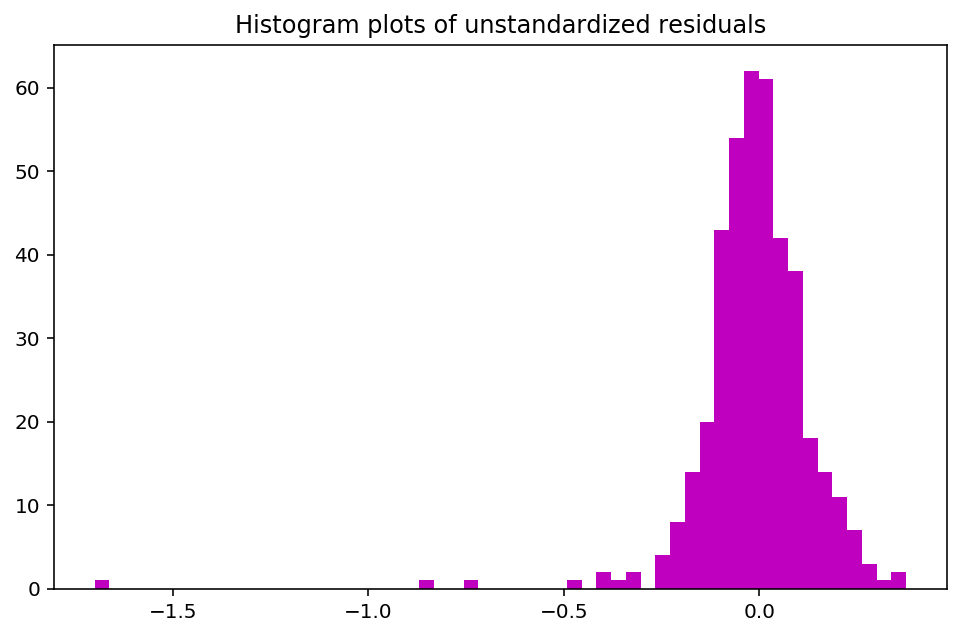

In [96]:
#hist plot for normality check
#errors are norm dist
plt.figure(figsize=(8,5))
plt.title('Histogram plots of unstandardized residuals')
plt.hist(residuals, bins= 55, color="m");

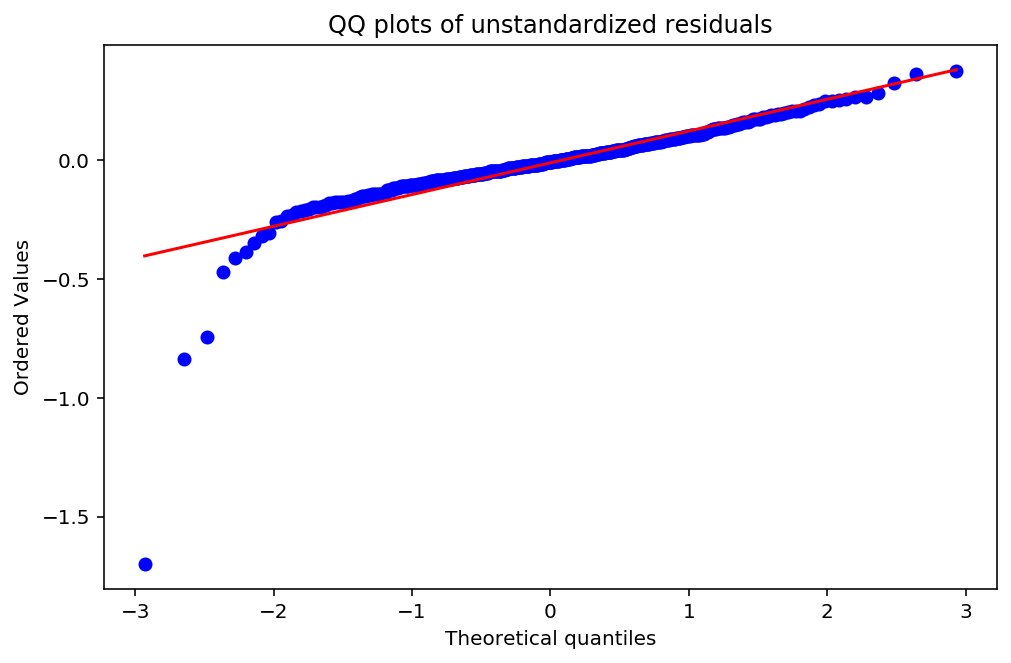

In [97]:
plt.figure(figsize=(8,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ plots of unstandardized residuals')
plt.show()

**Normally distributed errors assumption** hold from QQ plots and histogram plots of unstandardized residuals. However, from pairplots during the EDA phase, we can see not all IVs are normally distributed. 

**Linearity** is assume to hold from pairplots during the EDA as visual inspection show variables are a linear combination. Quadratic terms for those which were did not look linear (total_SF, age_when_sold) were included in the analysis. 

In [98]:
predicts = lasso.predict(X_test_sc)

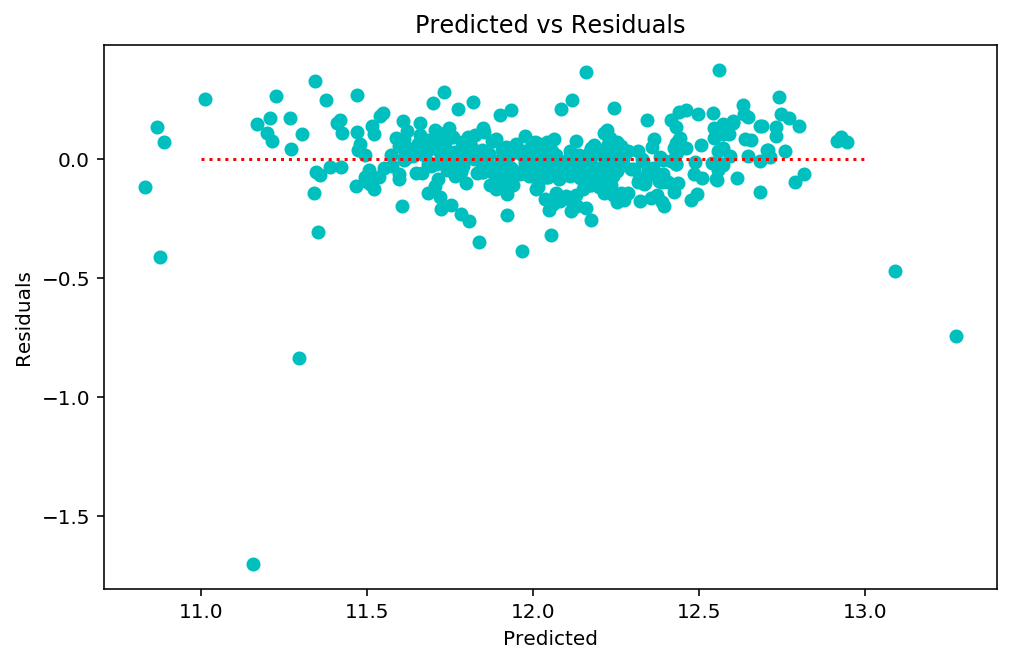

In [99]:
#check whether we have homoskedasticity (equal variance in our error terms) or heteroskedasticity (unequal variance)
#error variance dont look like it fan in or out so Equality of error assume to hold 

plt.figure(figsize=(8,5))
plt.plot(predicts,residuals,'o', c="c")
plt.plot([11, 13], [0, 0], ':', color = 'r')

plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.tick_params(axis='x')
plt.tick_params(axis='y')

**Independence of error** are inspected from the 'Predicted vs Residuals' plots. If the residuals are distributed uniformly randomly around the zero x-axes and do not form specific clusters, then the assumption holds true. Visual inspection confirms the independence of error.


**Constant error variance (equality)** is assume to hold as error variance dont look like it fan in or out when we plot Predicted vs Residuals.


In [100]:
diag_df=X_test[survivals['variable']]
diag_df.head()

total_SF  total_SF_sq  Overall Qual  age_when_sold  Overall Cond  \
1124    2441.0    5958481.0           5.0           30.0           5.0   
188     3634.0   13205956.0           7.0           40.0           6.0   
1727    3716.0   13808656.0           8.0            1.0           5.0   
1658    2871.0    8242641.0           6.0           95.0           4.0   
1424    3271.0   10699441.0           7.0            0.0           5.0   

      age_since_reno  Lot Area  total_bath  Fireplaces  TotRms AbvGrd  ...  \
1124            30.0   10780.0         1.0         0.0            6.0  ...   
188             40.0   14200.0         2.5         2.0            8.0  ...   
1727             1.0    8899.0         2.5         1.0           10.0  ...   
1658            60.0    6858.0         2.5         0.0            6.0  ...   
1424             0.0    8581.0         2.5         0.0            7.0  ...   

      Mas Vnr Area  Garage Finish  Misc Val  Wood Deck SF  Lot Frontage  \
1124           0.0            1.0       0.0           0.0          55.0   
188          309.0            3.0       0.0         105.0          88.0   
1727         108.0            3.0       0.0         100.0          74.0   
1658           0.0            1.0       0.0           0.0          66.0   
1424           0.0            2.0       0.0           0.0          74.0   

      Land Slope  Lot Shape  Pool Area  BsmtFin Type 2  age_garage  
1124         1.0        3.0        0.0             1.0        30.0  
188          1.0        4.0        0.0             1.0        40.0  
1727         1.0        4.0        0.0             1.0         1.0  
1658         1.0        4.0        0.0             1.0        90.0  
1424         1.0        3.0        0.0             1.0         0.0  

[5 rows x 25 columns]

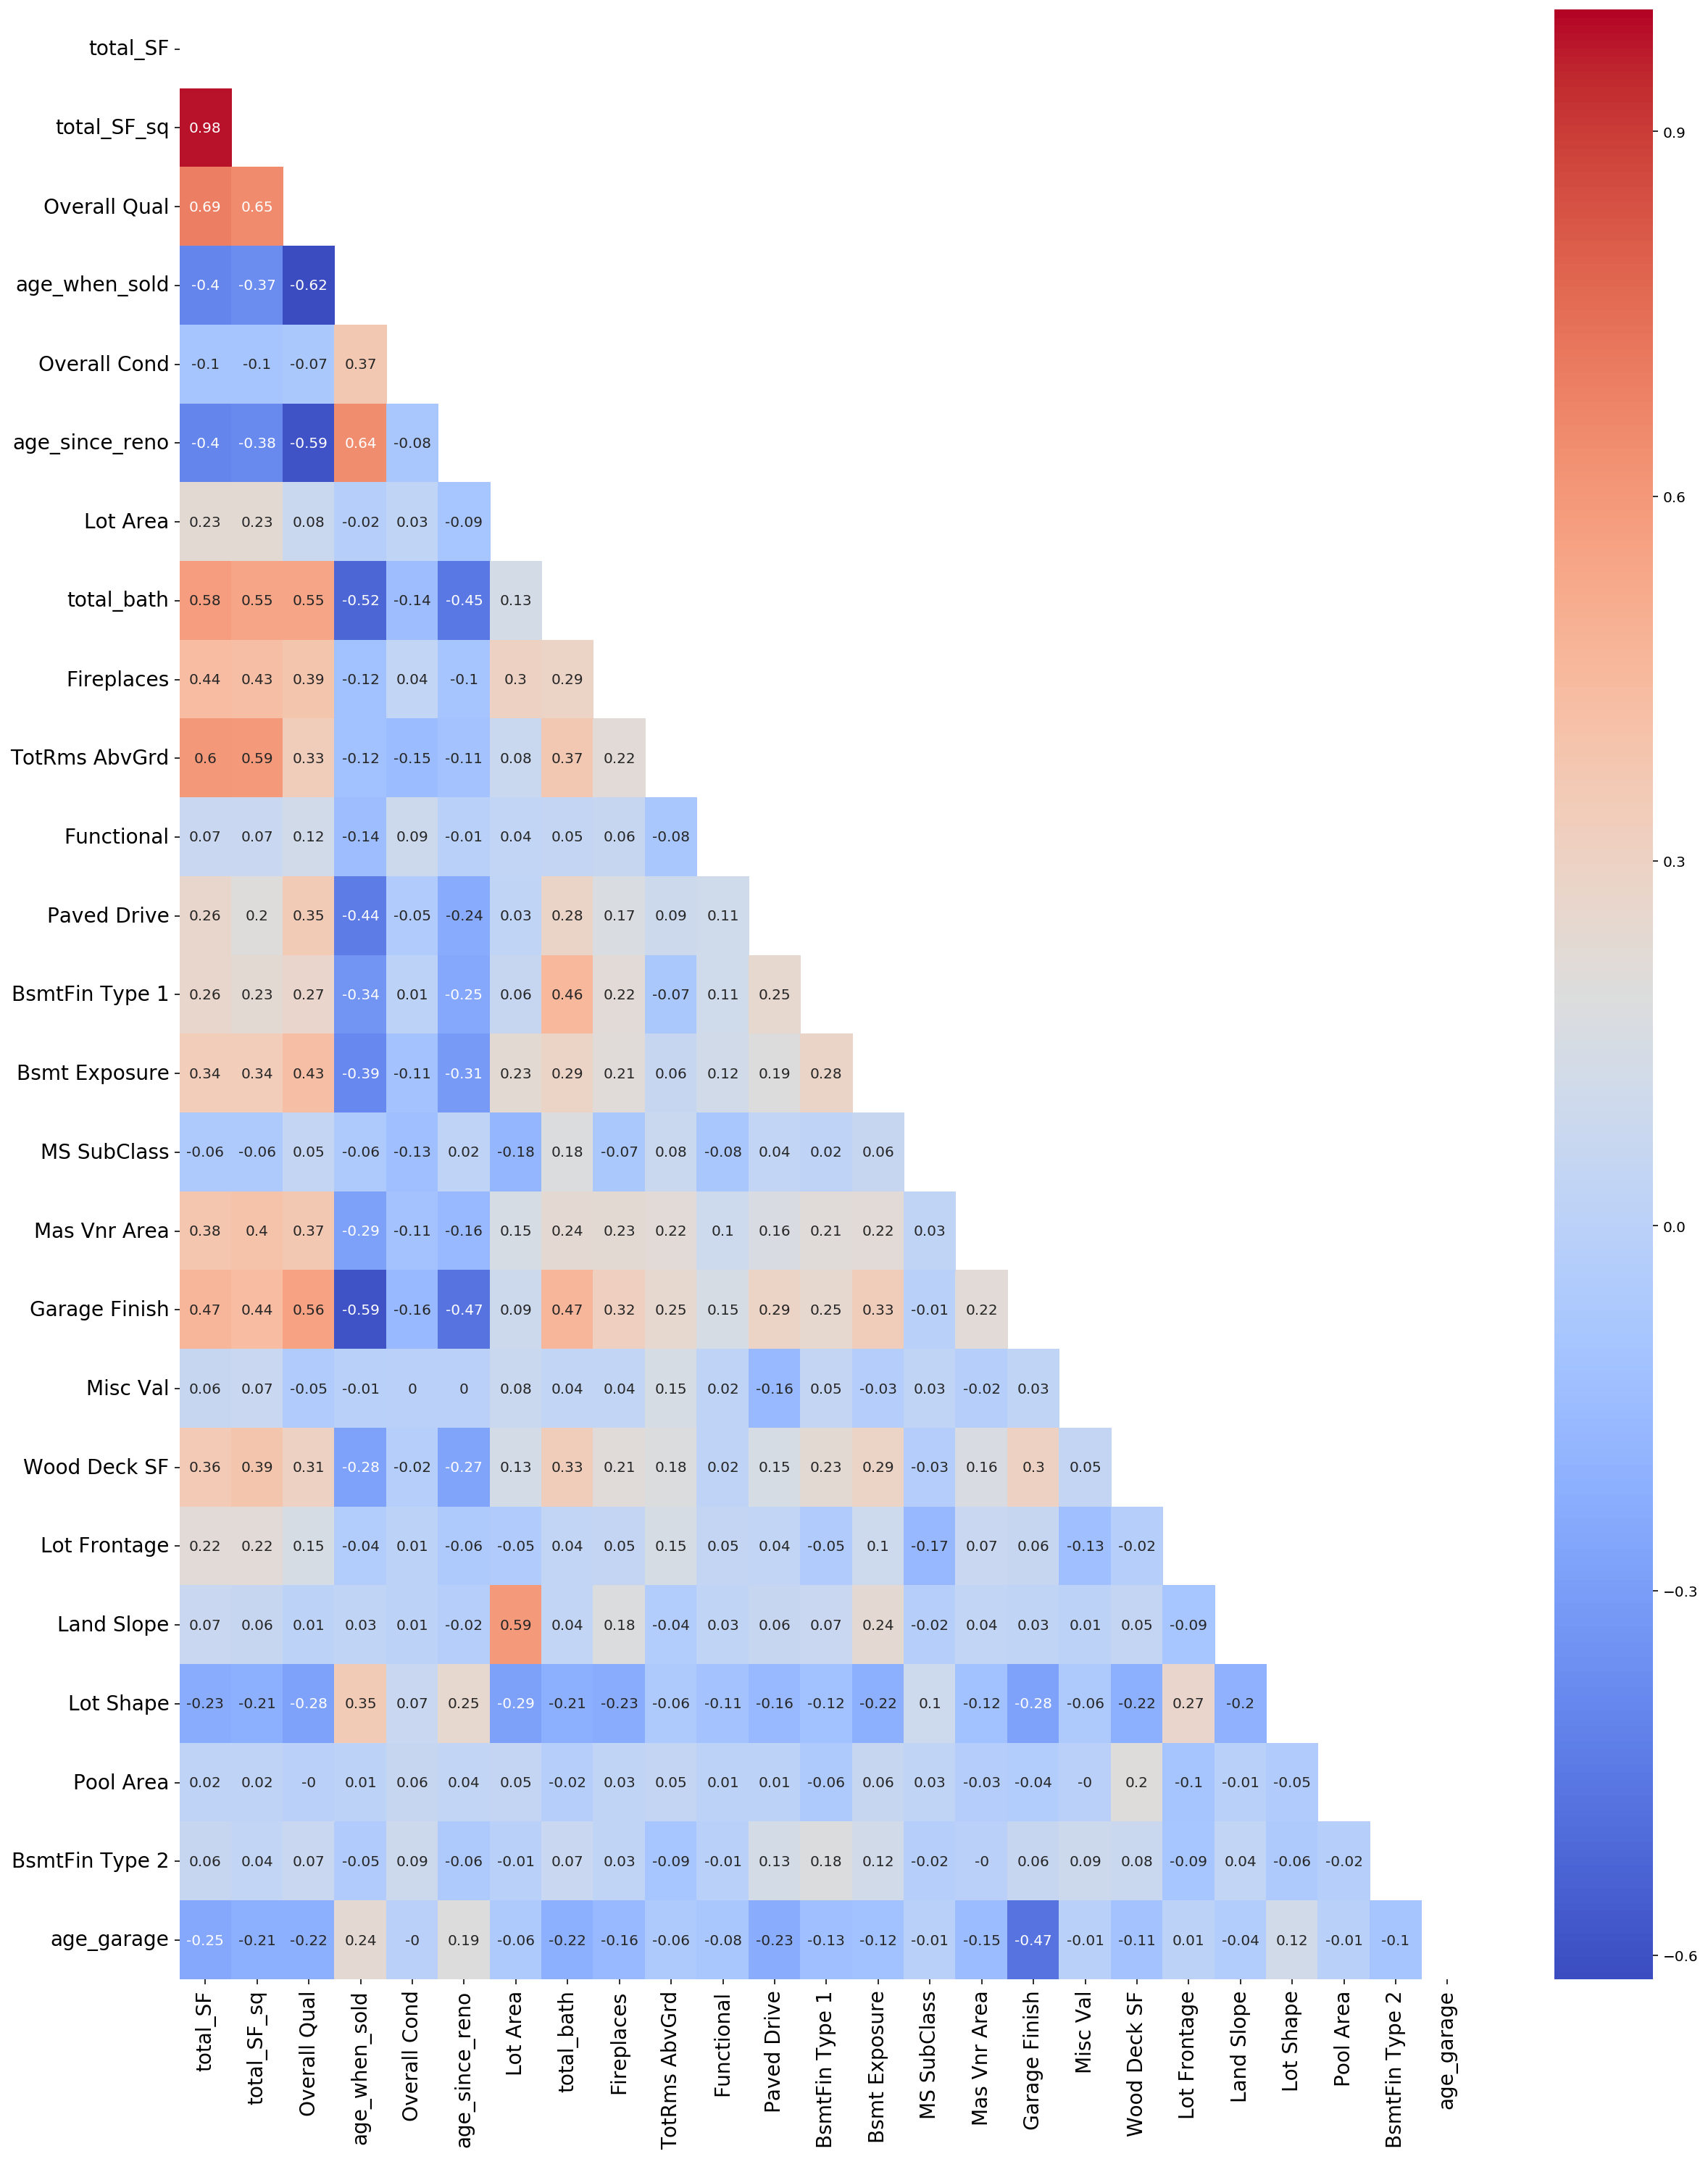

In [101]:
diag_df_corr=round(diag_df.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(20,25))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(diag_df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.

ax = sns.heatmap(diag_df_corr,mask=mask, ax=ax, annot=True, cmap='coolwarm')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, va="center")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top -0.5)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

**Multicolinearity** has been inspected through the heatmap plotted. As most continuous and ordinal variables are not highly correlated (r = 0.5) with each other, this assumption is assume to hold. Furthermore, the Lasso regression would reduce multicolinearity further. 

## Predicting an unseen data set

The next step is to fit the holdout set into this model and predict its scores.  

The kaggle score obtain by this model is 31603.66015 which is within the Top 50 for that particular competition. 

<details><summary>Drop down for plots</summary>
    
![](images/kaggle.png)
</details>

In [102]:
final_test_df.head()

Id          PID  MS SubClass  Lot Frontage  Lot Area  Lot Shape  \
0  2658.0  902301120.0        190.0          69.0    9142.0        4.0   
1  2718.0  905108090.0         90.0           0.0    9662.0        3.0   
2  2414.0  528218130.0         60.0          58.0   17104.0        3.0   
3  1989.0  902207150.0         30.0          60.0    8520.0        4.0   
4   625.0  535105100.0         20.0           0.0    9500.0        3.0   

   Land Slope  Overall Qual  Overall Cond  Mas Vnr Area  ...  \
0         1.0           6.0           8.0           0.0  ...   
1         1.0           5.0           4.0           0.0  ...   
2         1.0           7.0           5.0           0.0  ...   
3         1.0           5.0           6.0           0.0  ...   
4         1.0           6.0           5.0         247.0  ...   

   Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  Bldg Type_TwnhsE  \
0               0.0               0.0              0.0               0.0   
1               0.0               0.0              0.0               0.0   
2               0.0               0.0              0.0               0.0   
3               0.0               0.0              0.0               0.0   
4               0.0               0.0              0.0               0.0   

   Garage Type_Attchd  Garage Type_Basment  Garage Type_BuiltIn  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   Garage Type_CarPort  Garage Type_Detchd  Garage Type_donthave  
0                  0.0                 0.0                   0.0  
1                  0.0                 0.0                   0.0  
2                  0.0                 0.0                   0.0  
3                  0.0                 0.0                   0.0  
4                  0.0                 0.0                   0.0  

[5 rows x 157 columns]

In [103]:
ivs = list(train_df.columns)

remove_iv = 'Id','PID','SalePrice', 'data_from'
for i in remove_iv:
    ivs.remove(i)
  

In [104]:
#choose x, y 
X_final_test=final_test_df[ivs]


In [105]:
X_final_test_sc = ss.transform(X_final_test)

In [106]:
pred = lasso.predict(X_final_test_sc)


In [107]:
#pred2 = enet.predict(X_final_test)

In [108]:
pred_df= pd.DataFrame()
pred_df['Id'] = final_test_df['Id']
pred_df['SalePrice'] = np.exp(pred)
pred_df.columns = ['Id','SalePrice']



In [109]:
pred_df['Id']=pred_df['Id'].astype("int32")

In [110]:
pred_df["SalePrice"]

0      155692.158922
1      176359.094386
2      214813.351468
3      112011.312493
4      183027.477365
           ...      
874    196072.583923
875    225933.818626
876    125416.893415
877    111906.427184
878    124041.874753
Name: SalePrice, Length: 879, dtype: float64

In [111]:
pred_df.to_csv('icesubmission.csv',index=False)

![](images/mysub.png)

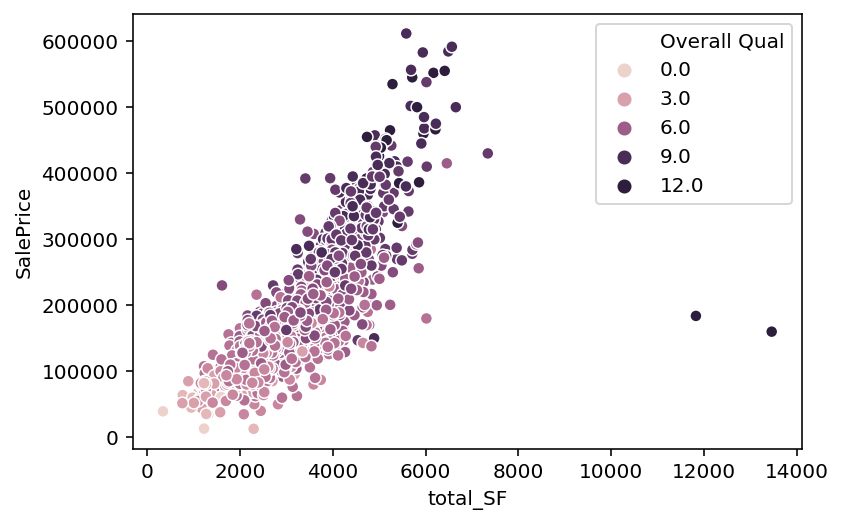

In [112]:
sns.scatterplot(x="total_SF", y="SalePrice", hue="Overall Qual", data=train_df)

## Discussion  

The top 5 predictors of sale price for a property in Ames is:
- Total_sf
- Overall Qual
- age_when_sold
- Overall Cond
- age_since_reno

**Interpretation**

With every feature held constant, the sale price of a property is about 167,081.54. 

One unit increase in Total SF increase the sale price by 0.307 when all else are held constant. There is a diminishing returns of 0.192 of sale price for every other unit increase in Total SF. That is, total SF's effect on sale prices decreases on level's of itself.

One unit increase in Overall Qual increases the sale price by 0.113. One unit increase in Overall Cond increases the sale price by 0.043. These makes sense as these are desirable traits. 

Each unit increase in age_when_sold increases the price by decreases sale price by 0.056. This might be because buyers prefer new properties to older ones. Similarly, every unit increase in age since renovation would decrease sale price by 0.034 as buyers may prefer properties that are more newly renovated. 

**Implications**

These findings have important practical implications. For anyone interested in sale prices of property such as property buyers, real estate firms, those looking to sell their property or even designers, the top 5 factors to consider that will increase the sale price of the property are total square feets, overall quality, age when sold, overall condition and age since renovation. 

Home designers, architects and developers may think about how to maximize total square feets. For instance, for a fixed plot of land, adding a basement and an additional level to the house can greatly increase total square feet, which associates to a higher sale price. Buyers, agents and investors may consider the total square feet when deciding on property to invest as well. 

When designing a house or building one, architects, designers and developers want to consider the quality of their build as it would likely associate with a higher sale price. In general, qualtity gives assurance to buyers and investors which leads to its high association with sale price despite the age. Conversely, low quality builds may hurt sale prices and deter buyers. 

Overall condition is especially important for homeowners. At times, maintaining a properties condition requires time and cost. Through this analysis, it seems that these efforts will pay off with a better sale price. Renovations also seem to be valued and associated with a higher sale price, especially the more recent the renovation was done. The reverse is true that a property in bad condition would hurt sale prices. This is likely linked to the fact that it improves the overall conditions. 

Contuary to what the market believe, neighborhood was not a significant predictor of sale price in Ames. This is perhaps due to the facr that Ames real estate is already some of the most expensive in Iowa, although Ames house values don't compare to the most expensive real estate in the USA. Furthermore, Ames is a decidedly white-collar city, with fully 88.03% of the workforce employed in white-collar jobs, well above the national average. Overall, Ames is a city of professionals, sales and office workers, and service providers. There are especially a lot of people living in Ames who work in teaching (17.25%), office and administrative support (11.91%), and food service (8.57%). Having this may mean that most neighborhoods in Ames are already well developed and roughly equal (https://www.neighborhoodscout.com/ia/ames).



## Limitations
This analysis is not without limitations. Firstly, outliers and extreme scores were many. These outleirs may have influeced the results of the analysis. In balancing between accuracy of predictions for the average property with the accurary of prediction for Ames as a whole, I have picked the latter at a cost of the former. By removing outliers and extreme scores, we would greatly improve our predictions on the average property in Ames. Research to follow may look into calculating how much leverage this points may have on the predictions and choose to develop a model that better fit the average of the population. 
 
Secondly, from pairplots during the EDA phase, we can see not all IVs are normally distributed. Apart from collecting more data, research to follow may consider transforming IVs so that they would have a more gaussian like distribution. 

It also seem like some of out variables may have potential interaction effects. Specifically, it seems that overall quality and age when sold may interact with each other to predict sale prices. Overall condition and age when renovation may also interact with each other. 

Lastly, the data is only from five years and the data was from 2006 to 2010 which is a decade ago. Prices and variables and the economy of Ames might have changed over 10 years.

Finally, this model is by no means generalizable to any state in the USA as the model has only been fed and trained by data colleted in Ames. In order to be able to generalize across other states, random samples from each state would be prefered. 